In [80]:
# reconstruct return correlation from https://www.arxiv.org/abs/2407.20380
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import poisson
import math
from numpy import linalg as LA
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web
import seaborn as sns
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
from random import sample
plt.style.use('fivethirtyeight')
#import yfinance as yf  
from yahoo_fin.stock_info import get_data
from scipy.stats import kurtosis
from scipy.stats import skew
import yfinance as yf

from pathlib import Path
import networkx as nx
from fa2_modified import ForceAtlas2
# python3 setup.py build_ext --inplace
from double_loop import filter_edges
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
import graphviz
import re
import pydot #https://github.com/pydot/pydot

In [81]:
def makegraph2(CorrM,dicstocks,dic_sector,thresh):
    

    ###################################### Gall
    Mg=CorrM
    
    Gall = nx.DiGraph()    
   
    cythonok=1
    if cythonok==1:
        e, nodes = filter_edges(Mg,thresh)
    else:
        
        e=[]
        nodes=[]
        for k in range(len(Mg)):
            for v in range(k):
                    
                w=Mg[k][v]
                if np.abs(w)>np.quantile(Mg,thresh) and v!=k: #CorrM.mean()+1.*CorrM.std():
                    e.append((k, v, {'weight': w}))
                    #e.append((k,v,w))
                    if k not in nodes:
                        nodes.append(k)
                    if v not in nodes:
                        nodes.append(v)

    
    print('len connected nodes/edges',len(nodes),len(e))
    
    
    Gall.add_nodes_from(dicstocks.keys()) # add all nodes 
    Gall=Gall.to_undirected()
    
    Gall.add_edges_from(e)


  
     #Crates graph using the data of the correlation matrix
    
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1, #How much influence you give to the edges weight. 0 is "no influence" and 1 is "normal"
    
                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED
    
                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=40.,
    
                            # Log
                            verbose=True)
    
    
    
    positions = forceatlas2.forceatlas2_networkx_layout(Gall, pos=None, iterations=4000)
    #positions=nx.circular_layout(G)

    dic_mod=find_cluster(Gall,1)
    print('nb of cluster G100=',len(set(dic_mod.values())))


    
    # color node per cluster identification 
    #col=makecollist(len(set(dic_mod.values())))
    #node_color = [col[dic_mod[v]] for v in G]
    eigenvector_centrality = nx.eigenvector_centrality_numpy(Gall,weight='weight')
    
    # color node per its sector:
    
    #col=makecollist(len(set(dic_sector.values())))
    unique_sectors = sorted(set(dic_sector.values()))
    col = makecollist(len(unique_sectors))
    sector_to_color = {sector: col[i] for i, sector in enumerate(unique_sectors)}
    # Shortened labels for legend (remove " S&P 500")
    sector_labels_short = [s.replace(' S&P 500', '') for s in unique_sectors]
    

    # Create patches with shortened labels
    legend_handles = [mpatches.Patch(color=col[i], label=sector_labels_short[i]) for i in range(len(unique_sectors))]
    
    ls=list(set(dic_sector.values()))
    node_color=[]
    labels={}
    centrality = dict(Gall.degree) #nx.betweenness_centrality(Gall)
    tcent=np.quantile(list(centrality.values()),0.9)

    #print('compute most influencial stock in the',len(set(dic_mod.values())),' communities')
    dic_commu_infl={}
    lcommu=list(dic_mod.values())
    for sec in list(set(dic_mod.values())):
        ncount=lcommu.count(sec)
        central=0
        nodeincommunity_sec=list(filter(lambda k: float(dic_mod[k]) ==sec, dic_mod))
        for ni in nodeincommunity_sec:
            if np.abs(eigenvector_centrality[ni])>=central and dic_mod[ni]==sec:
                dic_commu_infl[sec]=ni
                central=eigenvector_centrality[ni]
                nleader=ni
        #print('central=',central,'node=',nleader,'name=',dicstocks[nleader]) 

    #print('most influencial stock per sectors=')
    dic_cluster_infl={}
    for sec in list(set(dic_sector.values())):
        central=0
        for ni in eigenvector_centrality.keys():
            n=dicstocks[ni]
            if eigenvector_centrality[ni]>central and dic_sector[n]==sec:
                dic_cluster_infl[sec]=ni
                central=eigenvector_centrality[ni]

    ttcent=np.quantile(list(eigenvector_centrality.values()),0.97)
    for v in Gall:
        name_v=dicstocks[v]
        index=ls.index(dic_sector[name_v])
        sector = dic_sector[name_v]  # Get sector name
        node_color.append(sector_to_color[sector])  # Get the color
       
        if (v in dic_commu_infl.values() and centrality[v]>2) or (eigenvector_centrality[v]>ttcent) or (v in dic_cluster_infl.values())  :
            labels[v]=dicstocks[v]
        else:
            labels[v]=''
    
  
        
    degree_sequence = sorted((d for n, d in Gall.degree()), reverse=True)
    dmax = max(degree_sequence)
        
    kmeanran=len(e)*2/len(CorrM)
        
    print('mean/median degree graph=',np.mean(degree_sequence),np.median(degree_sequence),'Poisson=',kmeanran)
    CCi=dict(nx.clustering(Gall, weight='weight'))
    clustering_sequence = list(CCi.values())
        
    fig = plt.figure("Degree", figsize=(8, 8))
 
    axgrid = fig.add_gridspec(5, 6)
        
    ax0 = fig.add_subplot(axgrid[0:3, :])

    nx.draw_networkx_nodes(Gall, positions,ax=ax0, node_color=node_color,node_shape="s",node_size=[v * 1 for v in centrality.values()], alpha=0.5)
    nx.draw_networkx_labels(Gall, positions, labels, font_size=10,font_family='sans-serif', font_color='black',ax=ax0)
    
    
    nx.draw_networkx_edges(Gall, positions,ax=ax0, edge_color = 'black',alpha=min(1,80./len(e)))
    
        

    dic_mod=find_cluster(Gall,1)
    ax0.set_title('Ncluster='+str(len(set(dic_mod.values())))+'  '+r'$\rho_c=$'+str(thresh))
    ax0.set_axis_off()

    

    ax0.legend(handles=legend_handles,loc='best',fontsize='x-small',frameon=True,ncol=1)  # You can try 3 if it's still large)

    
    ax0.set_xlim([-630,520])
    ax0.set_ylim([-605,565])
        
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.axvline(x=np.mean(degree_sequence), color='red', ls='--',lw=1.5,label='median')
        #ax1.axvline(x=(kmeanran+1./3-1./(50*kmeanran)), color='black',ls='--',lw=1.5, label='median')
        #ax1.axvline(x=np.mean(degree_sequence), color='blue',ls='--',lw=1.5, label='median')
        #ax1.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
        #ax1.set_title("Degree ")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    ax1.set_xlim(0,Nstocks)
        
    ax2 = fig.add_subplot(axgrid[3:, 2:4])
    ax2.axvline(x=np.mean(degree_sequence),color='red',ls='--',lw=1.5, label='median')
        #ax2.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
        #ax2.bar(*np.unique(degree_sequence, return_counts=True))
    degree_sequence2=list(eigenvector_centrality.values())
    ax2.hist(degree_sequence2)
    ax2.set_xlim(min(degree_sequence2),max(degree_sequence2))
        #r = poisson.rvs(np.mean(degree_sequence), size=870)
        #ax2.hist(r,bins=[i for i in range(870)],histtype=u'step')

    ax3 = fig.add_subplot(axgrid[3:, 4:])
    ax3.axvline(x=np.mean(clustering_sequence),color='red',ls='--',lw=1.5, label='median')
        #ax2.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
    ax3.hist(clustering_sequence,bins=[i/100. for i in range(100)])
    ax3.set_xlim(min(clustering_sequence),max(clustering_sequence))
        #ax2.set_title("Degree histogram")
        #ax3.set_title("Clustering histogram")
    ax3.set_ylabel("# of Nodes")
    ax3.set_xlabel("Clustering")
    ax2.set_xlabel("vector centrality")
    ax2.set_ylabel("# of Nodes")
    ax1.set_xlim(0,Nstocks)
        
    fig.tight_layout()
    plt.savefig('network_market_stat_2024.png', dpi=300, bbox_inches='tight')
    plt.clf() 
    return Gall

def find_cluster(G,res):
    ###### given a graph G and a resolution return the dictionary of the module for each node
    mods=nx.community.louvain_communities(G, weight='weight', resolution=res, threshold=1e-07, max_level=None, seed=1271)
    dic_mod={}
    for iclus in range(len(mods)):
        for user in mods[iclus]:
            dic_mod[user]=iclus


    #nx.is_weighted(Gall)
    #ww=nx.get_edge_attributes(Gall,'weight')
    return dic_mod
    

def read_downloaddata(download,start,end):

    if download==1:
        # for the stocks 
        tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
        df1 = yf.download(tickers.Symbol.str.strip().to_list(),start,end, auto_adjust=True)['Close']
        
 
    
        df =df1 #pd.merge(df_temp, df3, on=['Date'])

      
        df.fillna(method='ffill', inplace=True) # fill nan with the last observed value
        df.dropna(axis = 1, how = 'any',inplace=True)
        df.to_csv('data_stocks/df_stocks_'+start+'_'+end+'.csv', index=False)
        
        # for the dictionary per sector 
        url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        # Send a GET request to the URL
        response = requests.get(url)
        # Parse the HTML content of the page with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the table with the class 'wikitable sortable'
        table = soup.find('table', {'class': 'wikitable sortable'})
        # Use pandas to read the HTML table
        dft = pd.read_html(str(table))[0]
        # Select only the columns 'Symbol' and 'GICS Sector'
        df_filtered500 = dft[['Symbol', 'GICS Sector']]
        df_filtered500['GICS Sector']=df_filtered500['GICS Sector'].apply(lambda x: x+' S&P 500')


        df_filtered=df_filtered500 #pd.concat([df_filtered500, df_filtered400], ignore_index=True)
        values=df_filtered['GICS Sector'].tolist()
        keys=df_filtered['Symbol'].tolist()
        dic_sector=dict(map(lambda i,j : (i,j) , keys,values))
        # Save the DataFrame to a CSV file
        df_filtered.to_csv('S&Pcompanies_dic.csv', index=False)
        
        return df, dic_sector
        
    else:
        df_filtered=pd.read_csv('S&Pcompanies_dic.csv')
        values=df_filtered['GICS Sector'].tolist()
        keys=df_filtered['Symbol'].tolist()
        dic_sector=dict(map(lambda i,j : (i,j) , keys,values))

        df=pd.read_csv('df_stocks_'+start+'_'+end+'.csv')

        return df,dic_sector
        


def computeCorrM(Stocks):
    #si=Stocks[:,stocki]
    Returns=[]
    Ret=[]
    Nstocks=len(Stocks[0])
    Time=len(Stocks[:,0])
    for i in range(Nstocks):
        si=Stocks[:,i]
        lr=[]
        for t in range(1,Time):
            lr.append(np.log(si[t])-np.log(si[t-1]))

        Ret.append(lr)
        #ri=(lr-np.mean(lr))/np.std(lr)
        ri=lr
        Returns.append(ri)
    
    
    CorrM=np.corrcoef(Returns) #np.cov(Returns)
    return CorrM,Ret

def MarchenkoPastur(Q,Lam,sig_r):
    #sig_r=1 # as the correlation matrix diagonal/variance is one 
    #sig_r=np.sqrt(1-L1/Nstocks)
    print('sig_r=',sig_r)
    Lmin=sig_r**2*(1-1/np.sqrt(Q))**2
    Lmax=sig_r**2*(1+1/np.sqrt(Q))**2
    Pdf=[]
    for x in Lam:
        if(Lmax-x)<0 or (x-Lmin)<0:
            Pdf.append(0)
        else:
            Pdf.append(Q/2./sig_r**2/np.pi*np.sqrt((Lmax-x)*(x-Lmin))/x)

    pdfnor=[i/sum(Pdf) for i in Pdf]
    return Lmin,Lmax,Pdf
    
def computeRmarket(Stocks):
    CorrM,Ret=computeCorrM(Stocks)
    eigenvalues, eigenvectors = LA.eig(CorrM)
    eigv=eigenvalues
    eigv.sort()
    Lmax=eigv[-1]
    indexmax=list(eigenvalues).index(Lmax)
    Umarket=eigenvectors[indexmax]
    Umarket=sum(eigenvectors)
    Rmarket=[]
    for time in range(1,len(Stocks)):
        RNt=0
        for istock in range(len(Stocks[0])-1):
            
            RNt+=Umarket[istock]*(np.log(Stocks[time,istock])-np.log(Stocks[time-1,istock]))
    
        Rmarket.append(RNt)
        
    print('mean, skew, kurto of Rmarket=',np.mean(Rmarket),skew(Rmarket),kurtosis(Rmarket))
    return Rmarket

def simulate_stock_priceGBM(S0, mu, sigma, T):
    """
    Simulate a stock price using Geometric Brownian Motion (GBM).

    Parameters:
    S0 (float): Initial stock price.
    mu (float): Drift coefficient (expected return).
    sigma (float): Volatility (standard deviation of returns).
    T (float): Total time period.
    dt (float): Time step.

    Returns:
    np.array: Simulated stock prices.
    """
    dt=1.#0.001
    N = int(T / dt)  # Number of time steps
    t = np.linspace(0, T, N)  # Time grid
    W = np.random.normal(size=N)  # Generate random numbers for Brownian motion
    W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum to generate Wiener process

    X = (mu-0.5*sigma**2)*t+sigma*W  # Log returns
    S = S0*np.exp(X)  # Stock prices

    return S


def simulate_stock_priceGBM_corr(S0, mu, sigma, T,coef,seedi):
    """
    Simulate a stock price using Geometric Brownian Motion (GBM).

    Parameters:
    S0 (float): Initial stock price.
    mu (float): Drift coefficient (expected return).
    sigma (float): Volatility (standard deviation of returns).
    T (float): Total time period.
    dt (float): Time step.

    Returns:
    np.array: Simulated stock prices.
    """
    
    dt=1.#0.001
    N = int(T / dt)  # Number of time steps
    t = np.linspace(0, T, N)  # Time grid
    
    np.random.seed(seed=None)
    W1 = np.random.normal(size=N)
    np.random.seed(seedi)
    W2 = np.random.normal(size=N)
    

    W=[]
    
    for i in range(N):
        W.append((W1[i]*(1.-coef)+coef*W2[i]))
    
    
    #W = np.random.normal(size=N)  # Generate random numbers for Brownian motion
    W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum to generate Wiener process

    X = (mu-0.5*sigma**2)*t+sigma*W  # Log returns
    S = S0*np.exp(X)  # Stock prices

    return S



def log_return(Stocki):
    Ri=[]
    T=len(Stocki)
    for i in range(1,T):
        Ri.append(np.log(Stocki[i])-np.log(Stocki[i-1]))
   # Ri=np.log(list_stock_prices).diff() 
    return Ri

def makecollist(size):
    if size>20:
        cmap = mpl.colormaps['viridis']
        
        color_list = [cmap(i / size) for i in range(size)]
        random.Random(4).shuffle(color_list)
        hex_colors = [mpl.colors.to_hex(color) for color in color_list]
    elif size>11:
        cmap = mpl.colormaps['tab20']
        color_list = [cmap(i) for i in range(size)]
    #random.shuffle(color_list)
        random.Random(4).shuffle(color_list)
        hex_colors = [mpl.colors.to_hex(color) for color in color_list]
    else:
        hex_colors=['sienna','red','darkorange','yellow','darkgreen','steelblue','dodgerblue','mediumblue','blueviolet','violet','turquoise']
    
    return hex_colors

def optimizedw_all(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering):
    Nstocks=len(Stocks[0])
    np.random.seed(seed=None)
    # compute pdf for data:
    CorrM,Ret=computeCorrM(Stocks)
    val_data=[]
    for i in range(len(CorrM)):
        for j in range(len(CorrM)):
            val_data.append(CorrM[i][j])

    w1,w2,w3=0.1880787886844406, 0.6137217685210369, 0.198199442794
    #w1=0.33
   # w2=0.64
    #w3=0.02
    print('initial weight=',w1,w2,w3)
    E=10000

    Ntrial=2
    for trial in range(Ntrial):
        #print(w1,w2,w3,trial)
        StocksRD=[]
        for istock in range(Nstocks):
            ######################### random correlation
            seedi=istock
            coef=0.
            s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ########################## correlation per sector
            namestock=dicstocks[istock]
            sector_stocki=dic_sector[namestock]
            seedi=seedsector[sector_stocki]
            scentral=dic_cluster_infl[sector_stocki]
            coef=np.abs(CorrM[istock][scentral])
            #s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            ############################# correlation per communities   
            seedi=dic_mod[istock]+1
            mod=dic_mod[istock]
            # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
            # 1-per community:
            #scentral=dic_commu_infl[mod]
            #coef=np.abs(CorrM[istock][scentral])
            #2- per clustering:
            coef=clustering[istock]
            s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ####################### correlation per market mode
            coef=0
            nor=0
            for n in market_stocks:
                if coef<np.abs(CorrM[istock][n]):
                    coef=CorrM[istock][n]
                    nor=1
             #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
             #   nor+=eigenvector_centrality[n]+central_rank[n]
            seedi=483
            coef=coef/nor
            s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            
            s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
            StocksRD.append(s)
                    
        StocksRD=np.array(StocksRD).T
        CorrMtest,Retsimu=computeCorrM(StocksRD)
        ###########################################################
        val_sim=[]
        for i in range(len(CorrMtest)):
            for j in range(len(CorrMtest)):
                val_sim.append(CorrMtest[i][j])


         # Perform KS Test
        statistic, p_value = ks_2samp(val_sim, val_data)
        #print(statistic,p_value,trial)
        w_distance = wasserstein_distance(val_sim, val_data)
        condi=0.5*w_distance+0.5*statistic
        if condi<E:
            E=condi
            pBF=p_value
            print('w1,w2,w3=',w1,w2,w3,E,trial)
            w1BF=w1#round(w1,2)
            w2BF=w2#round(w2,2)
            w3BF=w3#round(w3,2)
        np.random.seed(seed=trial)     
        w1=w1BF+np.random.normal(loc=0, scale=0.04, size=None)
        np.random.seed(seed=trial*3)  
        w2=w2BF+np.random.normal(loc=0, scale=0.03, size=None)
        w3=1-w1-w2 
        
        if w1<0 or w1>=1 or w2>=1 or w2<0 or w3<0 or w3>=1:
            w3=w3BF
            w2=w2BF
            w1=w1BF
        
    print('Err=',w_distance,statistic,p_value)
    print('WBF=',w1BF,w2BF,w3BF)
    
    return w1BF,w2BF,w3BF
        


def optimizedw_market(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mdata):
    Nstocks=len(Stocks[0])
   
    # compute pdf for data:
    CorrM,Ret=computeCorrM(Stocks)
    val_data=[]
    for i in range(len(CorrM)):
        for j in range(len(CorrM)):
            val_data.append(Mdata[i][j])

    w1,w2,w3=0.25949147598549144, 0.7405085240145086,0
    
    w1BF,w2BF,w3BF=w1,w2,w3
    print('initial weight=',w1,w2,w3)
  
    E=100000

    Ntrial=10
    for trial in range(Ntrial):
        #print(w1,w2,w3,trial)
        StocksRD=[]
        for istock in range(Nstocks):
            ######################### random correlation
            seedi=istock
            coef=0.
            s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ########################## correlation per sector
            namestock=dicstocks[istock]
            sector_stocki=dic_sector[namestock]
            seedi=seedsector[sector_stocki]
            scentral=dic_cluster_infl[sector_stocki]
            coef=np.abs(CorrM[istock][scentral])
            # =simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            ############################# correlation per communities   
            seedi=dic_mod[istock]+1
            mod=dic_mod[istock]
            # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
            # 1-per community:
            #scentral=dic_commu_infl[mod]
            #coef=np.abs(CorrM[istock][scentral])
            #2- per clustering:
            coef=clustering[istock]
            s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ####################### correlation per market mode
            coef=0
            nor=0
            for n in market_stocks:
                if coef<np.abs(CorrM[istock][n]):
                    coef=CorrM[istock][n]
            
            nor=1
             #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
             #   nor+=eigenvector_centrality[n]+central_rank[n]
            seedi=483
            coef=coef/nor
            s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            
            s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
            StocksRD.append(s)
                    
        StocksRD=np.array(StocksRD).T
        CorrMtest,Retsimu=computeCorrM(StocksRD)
        ###########################################################
        val_sim=[]
        for i in range(len(CorrMtest)):
            for j in range(len(CorrMtest)):
                val_sim.append(CorrMtest[i][j])

         # Perform KS Test
        statistic, p_value = ks_2samp(val_sim, val_data)
        #print(statistic,p_value,trial)
        w_distance = wasserstein_distance(val_sim, val_data)
        condi=0.5*w_distance+0.5*statistic
        if condi<E:
            E=condi
            pBF=p_value
            print('w1,w2bf=',w1,w2,E,trial)
            w1BF=w1#round(w1,2)
            w2BF=w2#round(w2,2)
            w3BF=0.#round(w3,2)
        np.random.seed(seed=trial)     
        r1=np.random.normal(loc=0, scale=0.03, size=None)        
        w1=w1BF+r1 
        w2=1.-w1
       

        if w1<0 or w1>=1 or w2>=1 or w2<0 or w3<0 or w3>=1:
            w1=w1BF
            w2=1-w1
        

    print('Err=',w_distance,statistic,p_value)
    print('WBF=',w1BF,w2BF,w3BF)
    return w1BF,w2BF,w3BF



def optimizedw_noise(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mdata):
    Nstocks=len(Stocks[0])
   
    # compute pdf for data:
    CorrM,Ret=computeCorrM(Stocks)
    val_data=[]
    for i in range(len(CorrM)):
        for j in range(len(CorrM)):
            val_data.append(Mdata[i][j])

    
    
    w1,w2,w3=0.01411532807793912, 0.0, 0.985884671922 #0.,0.,1. #0.03, 0.0, 0.97
    w1BF,w2BF,w3BF=w1,w2,w3
    print('initial weight=',w1,w2,w3)
    E=10000

    Ntrial=5
    for trial in range(Ntrial):
        #print(w1,w2,w3,trial)
        StocksRD=[]
        for istock in range(Nstocks):

            ######################### random correlation
            seedi=istock
            coef=0.
            s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            ########################## correlation per sector
            namestock=dicstocks[istock]
            sector_stocki=dic_sector[namestock]
            seedi=seedsector[sector_stocki]
            scentral=dic_cluster_infl[sector_stocki]
            coef=np.abs(CorrM[istock][scentral])
            #s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            ############################# correlation per communities   
            seedi=dic_mod[istock]+1
            mod=dic_mod[istock]
            # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
            # 1-per community:
            #scentral=dic_commu_infl[mod]
            #coef=np.abs(CorrM[istock][scentral])
            #2- per clustering:
            coef=clustering[istock]
            s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ####################### correlation per market mode
            coef=0
            nor=0
            for n in market_stocks:
                if coef<np.abs(CorrM[istock][n]):
                    coef=CorrM[istock][n]
                    nor=1
             #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
             #   nor+=eigenvector_centrality[n]+central_rank[n]
            seedi=483
            coef=coef/nor
            s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            
            s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
            StocksRD.append(s)
                    
        StocksRD=np.array(StocksRD).T
        CorrMtest,Retsimu=computeCorrM(StocksRD)
        ###########################################################
        val_sim=[]
        for i in range(len(CorrMtest)):
            for j in range(len(CorrMtest)):
                val_sim.append(CorrMtest[i][j])
         # Perform KS Test
        statistic, p_value = ks_2samp(val_sim, val_data)
        #print(statistic,p_value,trial)
        w_distance = wasserstein_distance(val_sim, val_data)
        condi=0.5*w_distance+0.5*statistic
        if condi<E:
            E=condi
            pBF=p_value
            print('w1,w3bf=',w1,w3,E,trial)
            w1BF=w1#round(w1,2)
            w2BF=0.#round(w2,2)
            w3BF=w3#round(w3,2)
        np.random.seed(seed=trial)     
        r1=np.random.normal(loc=0, scale=0.0031, size=None)
        
        
        w1=w1BF+r1 
        w3=1.-w1
       

        if w1<0 or w1>=1 or w2>=1 or w2<0 or w3<0 or w3>=1:
            w1=w1BF
            w3=1-w1
            w2=0
    print('Err=',w_distance,statistic,p_value)
    print('WBF=',w1BF,w2BF,w3BF)

    return round(w1BF,2),round(w2BF,2),round(w3BF,2)


def compute_Mmarket_Mnoise(Stocks,market_stocks):
    # compute the CorrM decomposition 
    
    CorrM,Ret=computeCorrM(Stocks)
    eigenvalues, z = LA.eig(CorrM)
    eigenvalues=eigenvalues.real
    Lcutmarket=eigenvalues[len(market_stocks)]
    print('Lcut=',Lcutmarket)
    eign=[]
    for i in range(len(CorrM)):
        if eigenvalues[i]<Lcutmarket: #<max(lu4,lu6):
            eign.append(eigenvalues[i]) 
        else:
            eign.append(0)
    Mnoise=np.dot(z,np.dot(np.diag(eign),z.T))
    
    
    
    
    eigm=[]
    for i in range(len(CorrM)):
        if eigenvalues[i]>Lcutmarket:
            eigm.append(eigenvalues[i])
            
        else:
            eigm.append(0)
    Mmarket=np.dot(z,np.dot(np.diag(eigm),z.T))


    for i in range(len(CorrM)):
        for j in range(len(CorrM)):
            Mmarket[i][j]=Mmarket[i][j]/np.sqrt(Mmarket[i][i]*Mmarket[j][j])
            Mnoise[i][j]=Mnoise[i][j]/np.sqrt(Mnoise[i][i]*Mnoise[j][j])

    return Mmarket, Mnoise


In [73]:
today = datetime.today().strftime('%Y-%m-%d')
start, end = '2019-01-01', '2024-01-01'
# for the historical evolution 
#'2011-01-01', '2016-01-01'
#'2001-01-01', '2006-01-01'
#'1991-01-01', '1996-01-01'
# for the Temperature 
#'2019-01-01', '2024-01-01'

# read or download the data 
download=0
df,dic_sector=read_downloaddata(download,start,end)


Time=len(df)
Nstocks=df.columns
labstocks=list(df.columns.values)
dicstocks={}
for i in range(len(labstocks)):
    dicstocks[i]=labstocks[i]
Nstocks=len(df.columns)
print('Time=',Time,'Nstock=',Nstocks)
Stocks=np.array(df)
Q=Time/Nstocks
print('Q=',Q)

print('len of sectors in list=',len(set(dic_sector.values())))
print(set(dic_sector.values()))

# compute CorrM and save matrix for Ricardo:
CorrM,Ret=computeCorrM(Stocks)
eigenvalues, z = LA.eig(CorrM)

Time= 1258 Nstock= 485
Q= 2.593814432989691
len of sectors in list= 11
{'Consumer Discretionary S&P 500', 'Utilities S&P 500', 'Energy S&P 500', 'Communication Services S&P 500', 'Consumer Staples S&P 500', 'Financials S&P 500', 'Information Technology S&P 500', 'Materials S&P 500', 'Health Care S&P 500', 'Real Estate S&P 500', 'Industrials S&P 500'}


In [74]:
Gall=makegraph2(CorrM,dicstocks,dic_sector,0.90)


dic_mod=find_cluster(Gall,1.)
#sec=list(set(dic_mod.values()))
clustering=dict(nx.clustering(Gall, weight='weight'))

sec=list(set(dic_sector.values()))
print(len(sec))
seedsector={}
ic=32
for seci in sec:
    seedsector[seci]=ic
    ic+=int(ic/2)
    


eigenvector_centrality = nx.eigenvector_centrality_numpy(Gall,weight='weight')
#central_voter=nx.voterank(Gall)

#central_rank=nx.pagerank(Gall,weight='weight')
#lpage=list(central_rank.values())


l=list(eigenvector_centrality.values())

#market_stocks=[]
#for key in eigenvector_centrality.keys():
#    if eigenvector_centrality[key]>np.quantile(l,0.978): # and central_rank[key]>np.quantile(lpage,0.97):
#        market_stocks.append(key)
#        namestock=dicstocks[key]
#        sector_stocki=dic_sector[namestock]

lmpmax=(1+(1/Q)**0.5)**2+0.15*(1+(1/Q)**0.5)**2 # buffer zone in principle should be treated separatly 
count_above = len([x for x in eigenvalues if x > lmpmax])
print('nb of eigenval above lMPmax=',count_above,lmpmax)
sorted_keys = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
# Select Nmarket stocks from count above MP
top_keys = sorted_keys[:count_above]      
market_stocks = []
for key in top_keys:
    market_stocks.append(key)
    namestock = dicstocks[key]
    sector_stocki = dic_sector[namestock]


print('most influencial stock per sectors=')
dic_cluster_infl={}
for sec in list(set(dic_sector.values())):
    central=0
    for ni in eigenvector_centrality.keys():
        n=dicstocks[ni]
        if eigenvector_centrality[ni]>central and dic_sector[n]==sec:
            dic_cluster_infl[sec]=ni
            central=eigenvector_centrality[ni]
            nleader=ni
    print(sec,central,nleader,dicstocks[nleader]) 

###############################

print('compute most influencial stock in the',len(set(dic_mod.values())),' communities')

dic_commu_infl={}
lcommu=list(dic_mod.values())
for sec in list(set(dic_mod.values())):
    ncount=lcommu.count(sec)
   # print('nb node in community',sec, '=',ncount)
    central=0
    nodeincommunity_sec=list(filter(lambda k: float(dic_mod[k]) ==sec, dic_mod))
    for ni in nodeincommunity_sec:
       
        if np.abs(eigenvector_centrality[ni])>=central and dic_mod[ni]==sec:
            
            dic_commu_infl[sec]=ni
            central=eigenvector_centrality[ni]
            nleader=ni
    #print('central=',central,'node=',nleader,'name=',dicstocks[nleader]) 


################################
print('list of market modes given by stocks with highest centrality/pagerank')
for n in market_stocks:
    print(n,dic_mod[n],dicstocks[n],eigenvector_centrality[n],dic_sector[dicstocks[n]])


Mmarket, Mnoise=compute_Mmarket_Mnoise(Stocks,market_stocks)

len connected nodes/edges 428 11519


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 321.21it/s]


BarnesHut Approximation  took  2.12  seconds
Repulsion forces  took  9.54  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.25  seconds
AdjustSpeedAndApplyForces step  took  0.29  seconds
nb of cluster G100= 72
mean/median degree graph= 47.50103092783505 36.0 Poisson= 47.50103092783505
11
nb of eigenval above lMPmax= 13 3.0214617093773994
most influencial stock per sectors=
Consumer Discretionary S&P 500 0.0907247916213943 271 LKQ
Utilities S&P 500 0.03199161467471578 139 DTE
Energy S&P 500 0.049092742336548034 261 KMI
Communication Services S&P 500 0.08140632073931629 236 IPG
Consumer Staples S&P 500 0.057473272931974184 415 SYY
Financials S&P 500 0.1331682176123525 29 AMP
Information Technology S&P 500 0.11515189864917673 421 TEL
Materials S&P 500 0.1114575669653807 83 CE
Health Care S&P 500 0.04721707522123734 237 IQV
Real Estate S&P 500 0.10331274904615777 476 WY
Industrials S&P 500 0.12758143537574765 359 PH
compute most influencial stock in the 72  com

<Figure size 800x800 with 0 Axes>

In [11]:
commu=list((dic_mod.values()))
ic=0
for val in list(set(dic_mod.values())):
    if commu.count(val)>1:
        ic+=1
print('nb of Louvain clusters with more than 1 stocks =',ic)

nb of Louvain clusters with more than 1 stocks = 15


initial weight= 0.25949147598549144 0.7405085240145086 0
w1,w2bf= 0.25949147598549144 0.7405085240145086 0.01482134070692158 0
Err= 0.01259323399705634 0.03882240408119886 1.863590219600888e-154
WBF= 0.25949147598549144 0.7405085240145086 0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean/std/skew/kurto sim noise= 0.5104571856905246 0.1664027407738316 -0.33933067539423384 -0.26876200548066276
mean/std/skew/kurto  noise= 0.5154211200743034 0.15648331437519106 -0.2998805460005875 0.045966330424453083


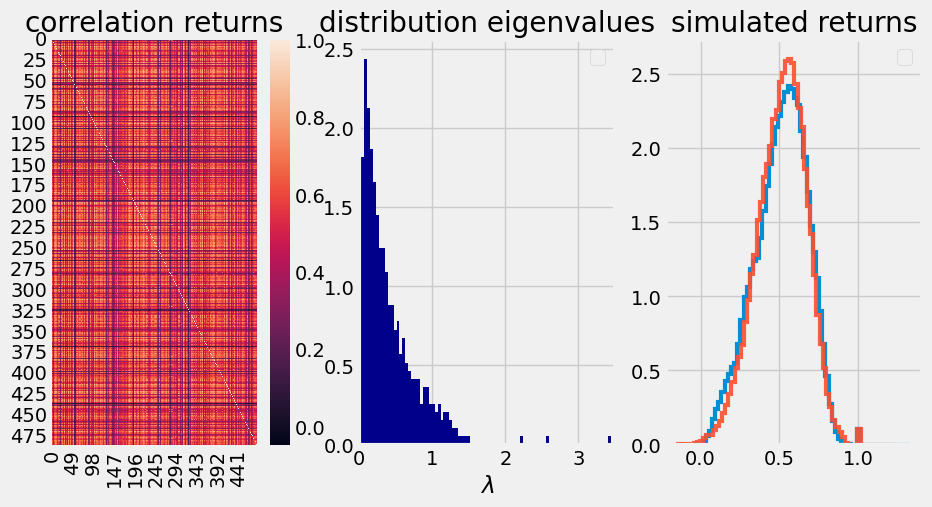

In [75]:
# simulate Market returns correlation  

CorrM,Ret=computeCorrM(Stocks)
StocksRD=[]
w1,w2,w3=optimizedw_market(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mmarket)
for istock in range(Nstocks):

    ######################### random correlation
    seedi=istock
    coef=0.
    s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    ########################## correlation per sectors 
    namestock=dicstocks[istock]
    sector_stocki=dic_sector[namestock]
    seedi=seedsector[sector_stocki]
    scentral=dic_cluster_infl[sector_stocki]
    coef=np.abs(CorrM[istock][scentral])
    #s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
    ############################# correlation per communities   
    seedi=dic_mod[istock]+1
    mod=dic_mod[istock]
    # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
    # 1-per community:
    #scentral=dic_commu_infl[mod]
    #coef=np.abs(CorrM[istock][scentral])
    #2- per clustering:
    coef=clustering[istock]
    s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
 
    
    coef=0
    nor=0
    for n in market_stocks:
        if coef<np.abs(CorrM[istock][n]):
            coef=CorrM[istock][n]
            
    nor=1
     #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
     #   nor+=eigenvector_centrality[n]+central_rank[n]
    seedi=483
    coef=coef/nor
    s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
    StocksRD.append(s)
    
StocksRD=np.array(StocksRD).T
CorrMsimu,Retsimu=computeCorrM(StocksRD)

###########################################################
CorrMtest=CorrMsimu
eigenvalues, z = LA.eig(CorrMtest)
   
fig2, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5))
sns.heatmap(CorrMtest, ax=axes[0], fmt='.1g', annot=False)
    
    
eigv=eigenvalues
eigv.sort()
    
binsL = np.linspace((min(eigv)),4,100)
axes[1].hist(eigenvalues,bins=binsL,density=True,color='darkblue')
    
counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))

 
axes[1].legend()

axes[0].set_title('correlation returns')
axes[1].set_title('distribution eigenvalues')
axes[1].set_xlabel(r'$\lambda$')

xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        xxsm.append(CorrMtest[i][j])
            
axes[2].set_title('simulated returns')
axes[2].hist(xxsm,bins=[min(xxsm)+0.02*i for i in range(70)],lw=3,histtype = 'step',density=True)
axes[2].legend()
print('mean/std/skew/kurto sim noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))
xxmarket_sim=xxsm
################################

CorrMtest=Mmarket
eigenvalues, z = LA.eig(CorrMtest)
    


    
eigv=np.real(eigenvalues)
eigv.sort()
binsL = np.linspace(max(0,min(eigv)),4,100)

counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[1][1].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[1][1].plot(binsL[1:],Pdf[1:],label='MPres')

   


axes[1].set_xlim(0, 3.5)


xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        
        xxsm.append(CorrMtest[i][j])
            

axes[2].hist(xxsm,bins=[min(xxsm)+0.02*i for i in range(70)],lw=3,histtype = 'step',density=True,alpha=0.9,label='returns')


print('mean/std/skew/kurto  noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))
################################






initial weight= 0.01411532807793912 0.0 0.985884671922
w1,w3bf= 0.01411532807793912 0.985884671922 0.01926299259485483 0
w1,w3bf= 0.01958389035043888 0.9804161096495612 0.018889285593741523 1
w1,w3bf= 0.024619360977794928 0.9753806390222051 0.0171798907737996 2
Err= 0.0023932175540594004 0.03642469975555329 5.172916794155998e-136
WBF= 0.024619360977794928 0.0 0.9753806390222051
sig_r= 1
sig_r= 0.9972633854547008


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean/std/skew/kurto sim noise= 0.0021307156739409855 0.053389606665264884 13.430194887015993 248.84471584567638
sig_r= 1
sig_r= 0.9949393647402515
mean/std/skew/kurto noise= 0.0008522851081106242 0.05482213156562882 12.689070411099243 226.2371052052971


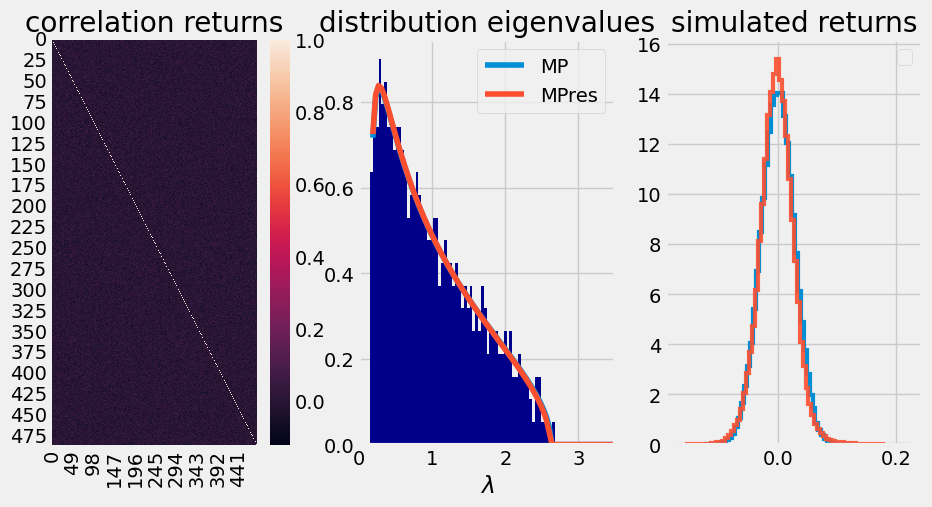

In [18]:
# simulate noise  returns correlation  

CorrM,Ret=computeCorrM(Stocks)
StocksRD=[]
w1,w2,w3=optimizedw_noise(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mnoise)
for istock in range(Nstocks):

    
    ######################### random correlation
    seedi=istock
    coef=0.
    s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
    
    ##########################correlation per sector
    namestock=dicstocks[istock]
    sector_stocki=dic_sector[namestock]
    seedi=seedsector[sector_stocki]
    scentral=dic_cluster_infl[sector_stocki]
    coef=np.abs(CorrM[istock][scentral])
    #s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
    ############################# correlation per communities   
    seedi=dic_mod[istock]+1
    mod=dic_mod[istock]
    # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
    # 1-per community:
    scentral=dic_commu_infl[mod]
    coef=np.abs(CorrM[istock][scentral])
    #2- per clustering:
    coef=clustering[istock]
    s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
    
    coef=0
    nor=0
    for n in market_stocks:
        if coef<np.abs(CorrM[istock][n]):
            coef=CorrM[istock][n]
            nor=1
     #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
     #   nor+=eigenvector_centrality[n]+central_rank[n]
    seedi=483
    coef=coef/nor
    s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)


    
    
    
    s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
    StocksRD.append(s)
    
StocksRD=np.array(StocksRD).T
CorrMsimu,Retsimu=computeCorrM(StocksRD)
###########################################################
CorrMtest=CorrMsimu
eigenvalues, z = LA.eig(CorrMtest)
   
fig2, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5))
sns.heatmap(CorrMtest, ax=axes[0], fmt='.1g', annot=False)
    
    #######
    
eigv=eigenvalues
eigv.sort()
    
binsL = np.linspace((min(eigv)),4,100)
axes[1].hist(eigenvalues,bins=binsL,density=True,color='darkblue')
    
counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[1].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[1].plot(binsL[1:],Pdf[1:],label='MPres')

   

    
axes[1].legend()

    
axes[0].set_title('correlation returns')
axes[1].set_title('distribution eigenvalues')
axes[1].set_xlabel(r'$\lambda$')

xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        xxsm.append(CorrMtest[i][j])
xxnoise_sim=xxsm                
axes[2].set_title('simulated returns')
axes[2].hist(xxsm,bins=[min(xxsm)+0.005*i for i in range(70)],lw=3,histtype = 'step',density=True)
axes[2].legend()
print('mean/std/skew/kurto sim noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))
################################

CorrMtest=Mnoise
eigenvalues, z = LA.eig(CorrMtest)
    


    
eigv=np.real(eigenvalues)
eigv.sort()
binsL = np.linspace(max(0,min(eigv)),4,100)

counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)

    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)


    

axes[1].set_xlim(0, 3.5)


xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        
        xxsm.append(CorrMtest[i][j])
 

axes[2].hist(xxsm,bins=[min(xxsm)+0.005*i for i in range(70)],lw=3,histtype = 'step',density=True,alpha=0.9,label='returns')

print('mean/std/skew/kurto noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))
################################

initial weight= 0.1880787886844406 0.6137217685210369 0.198199442794
w1,w2,w3= 0.1880787886844406 0.6137217685210369 0.198199442794 0.025318735731038957 0
Err= 0.06562095267297352 0.22865766819003075 0.0
WBF= 0.1880787886844406 0.6137217685210369 0.198199442794


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean/std/skew/kurto sim noise= 0.4030674757269696 0.14835934663280703 0.06426561359131547 -0.07932918404535094
mean/std/skew/kurto noise= 0.40635892169935073 0.13688793478265057 0.1111509739661781 0.5689287371394749


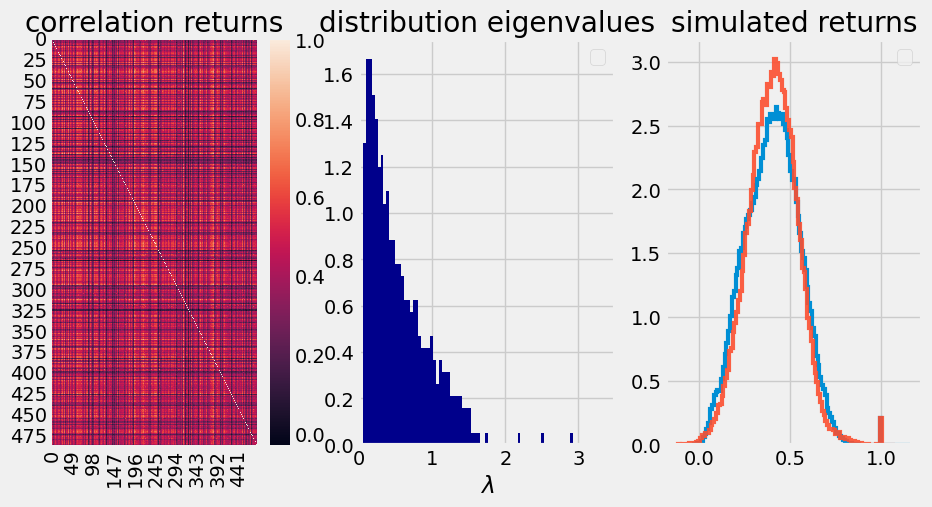

In [77]:
# simulate stock returns correlation  

w1,w2,w3=optimizedw_all(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering)

CorrM,Ret=computeCorrM(Stocks)
StocksRD=[]

for istock in range(Nstocks):

    ########################## correlation random
    coef=0.
    seedi=istock
    s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    ##################### introduce correlation per sector
    namestock=dicstocks[istock]
    sector_stocki=dic_sector[namestock]
    seedi=seedsector[sector_stocki]
    scentral=dic_cluster_infl[sector_stocki]
    coef=np.abs(CorrM[istock][scentral])
    #s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
    ############################# correlation per communities   
    seedi=dic_mod[istock]+1
    mod=dic_mod[istock]
    # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
    # 1-per community:
    scentral=dic_commu_infl[mod]
    coef=np.abs(CorrM[istock][scentral])
    #2- per clustering:
    coef=clustering[istock]
    s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    
    
    coef=0
    nor=0
    for n in market_stocks:
        if coef<np.abs(CorrM[istock][n]):
            coef=CorrM[istock][n]
            nor=1
     #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
     #   nor+=eigenvector_centrality[n]+central_rank[n]
    seedi=483
    coef=coef/nor
    s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)

    s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
    StocksRD.append(s)
    
StocksRD=np.array(StocksRD).T
CorrMsimu,Retsimu=computeCorrM(StocksRD)
###########################################################
CorrMtest=CorrMsimu
eigenvalues, z = LA.eig(CorrMtest)
   
fig2, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5))
sns.heatmap(CorrMtest, ax=axes[0], fmt='.1g', annot=False)
    
    #######
    
eigv=eigenvalues
eigv.sort()
    
binsL = np.linspace((min(eigv)),4,100)
axes[1].hist(eigenvalues,bins=binsL,density=True,color='darkblue')
    
counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[0][1].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[0][1].plot(binsL[1:],Pdf[1:],label='MPres')

   

    
axes[1].legend()

    
axes[0].set_title('correlation returns')
axes[1].set_title('distribution eigenvalues')
axes[1].set_xlabel(r'$\lambda$')

xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        xxsm.append(CorrMtest[i][j])
            
axes[2].set_title('simulated returns')
axes[2].hist(xxsm,bins=[min(xxsm)+0.01*i for i in range(120)],lw=3,histtype = 'step',density=True)
axes[2].legend()
print('mean/std/skew/kurto sim noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))

xxall_sim=xxsm    
CorrM_sim=CorrMtest
################################

CorrMtest=CorrM
eigenvalues, z = LA.eig(CorrMtest)
    


    
eigv=np.real(eigenvalues)
eigv.sort()
binsL = np.linspace(max(0,min(eigv)),4,100)

counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[1][1].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
#Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
#axes[1][1].plot(binsL[1:],Pdf[1:],label='MPres')

   

    

#axes[0][0].set_ylim(-0.5, 2.)
#axes[0][0].set_xlim(0, 3.5)
    


axes[1].set_xlim(0, 3.5)


xxsm=[]
for i in range(len(CorrMtest)):
    for j in range(len(CorrMtest)):
        
        xxsm.append(CorrMtest[i][j])
            
axes[2].hist(xxsm,bins=[min(xxsm)+0.01*i for i in range(120)],lw=3,histtype = 'step',density=True,alpha=0.9,label='returns')


print('mean/std/skew/kurto noise=',np.mean(xxsm),np.std(xxsm),skew(xxsm),kurtosis(xxsm))
################################

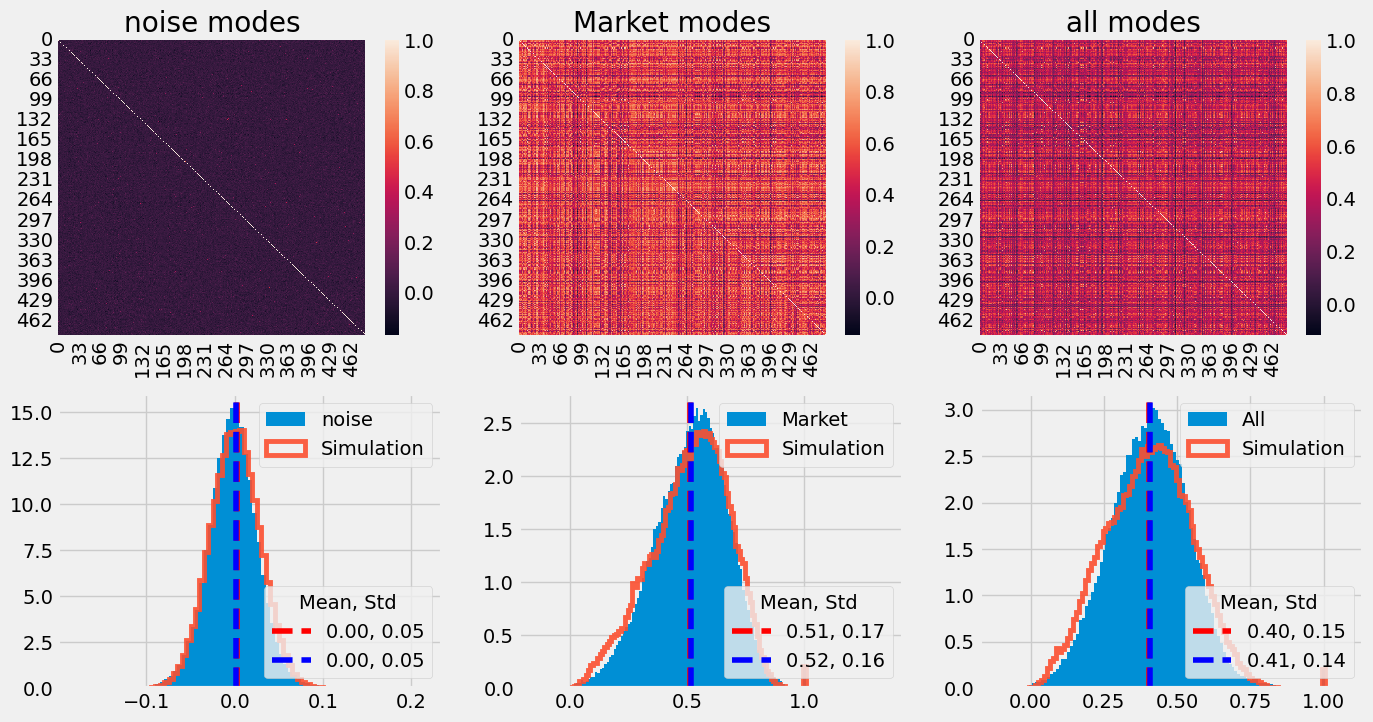

In [78]:
# Figure




fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,8))
sns.heatmap(Mnoise, ax=axes[0][0], fmt='.1g', annot=False)
axes[0][0].set_title('noise modes')

sns.heatmap(Mmarket, ax=axes[0][1], fmt='.1g', annot=False)
axes[0][1].set_title('Market modes')

sns.heatmap(CorrM, ax=axes[0][2], fmt='.1g', annot=False)
axes[0][2].set_title('all modes')

###########################################################
xxall=[]
for i in range(len(CorrM)):
    for j in range(len(CorrM)):
        xxall.append(CorrM[i][j])

# Plot histograms for "all" modes
axes[1][2].hist(xxall, bins=[min(xxall)+0.01*i for i in range(120)], density=True, label='All')
axes[1][2].hist(xxall_sim, bins=[min(xxall)+0.01*i for i in range(120)], lw=3.5, histtype='step', density=True, alpha=0.9, label='Simulation')
legend1 = axes[1][2].legend(loc='upper right')

# Vertical lines for mean and std
line1 = axes[1][2].axvline(np.mean(xxall_sim), color='red', linestyle='--',
                           label=f'{np.mean(xxall_sim):.2f}, {np.std(xxall_sim):.2f}')
line2 = axes[1][2].axvline(np.mean(xxall), color='blue', linestyle='--',
                           label=f'{np.mean(xxall):.2f}, {np.std(xxall):.2f}')
legend2 = axes[1][2].legend(handles=[line1, line2], loc='lower right', title='Mean, Std')
axes[1][2].add_artist(legend1)



xxm=[]
for i in range(len(Mmarket)):
    for j in range(len(Mmarket)):
        xxm.append(Mmarket[i][j])
axes[1][1].hist(xxm,bins=[min(xxm)+0.01*i for i in range(150)],density=True,label='Market')
axes[1][1].hist(xxmarket_sim,bins=[min(xxm)+0.01*i for i in range(150)],lw=3.5,histtype = 'step',density=True,alpha=0.9,label='Simulation')
#axes[1][1].legend()

legend1 = axes[1][1].legend(loc='upper right')

# Vertical lines for mean and std
line1 = axes[1][1].axvline(np.mean(xxmarket_sim), color='red', linestyle='--',
                           label=f'{np.mean(xxmarket_sim):.2f}, {np.std(xxmarket_sim):.2f}')
line2 = axes[1][1].axvline(np.mean(xxm), color='blue', linestyle='--',
                           label=f'{np.mean(xxm):.2f}, {np.std(xxm):.2f}')
legend2 = axes[1][1].legend(handles=[line1, line2], loc='lower right', title='Mean, Std')
axes[1][1].add_artist(legend1)




xxn=[]
for i in range(len(Mnoise)):
    for j in range(len(Mnoise)):
        xxn.append(Mnoise[i][j])

axes[1][0].hist(xxn,bins=[-0.18+0.005*i for i in range(80)],density=True,label='noise')
axes[1][0].hist(xxnoise_sim,bins=[-0.18+0.005*i for i in range(80)],lw=3.5,histtype = 'step',density=True,alpha=0.9,label='Simulation')
axes[1][0].legend()


legend1 = axes[1][0].legend(loc='upper right')

# Vertical lines for mean and std
line1 = axes[1][0].axvline(np.mean(xxnoise_sim), color='red', linestyle='--',
                           label=f'{np.mean(xxnoise_sim):.2f}, {np.std(xxnoise_sim):.2f}')
line2 = axes[1][0].axvline(np.mean(xxn), color='blue', linestyle='--',
                           label=f'{np.mean(xxn):.2f}, {np.std(xxn):.2f}')
legend2 = axes[1][0].legend(handles=[line1, line2], loc='lower right', title='Mean, Std')
axes[1][0].add_artist(legend1)

fig.savefig('Fig_comp_noise_market_all_yr2024_articlev2.png')

minmax= 0.002830015051811574 203.8651178058525
sig_r= 1
sig_r= 0.7613537620027684
minmax= 0.05520751089872966 209.36883514116153
sig_r= 1
sig_r= 0.7538644971885308


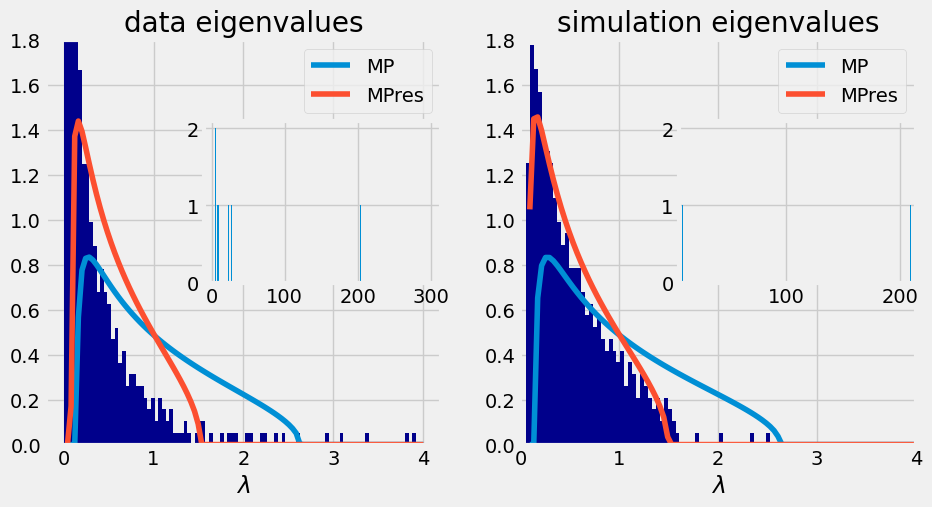

In [26]:
   
fig2, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
########################
eigenvalues, z = LA.eig(CorrM)    
eigv=eigenvalues
eigv.sort()
print('minmax=',eigv[0],eigv[-1])    
binsL = np.linspace((min(eigv)),4,100)
axes[0].hist(eigenvalues,bins=binsL,density=True,color='darkblue')
    
counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[0].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[0].plot(binsL[1:],Pdf[1:],label='MPres')

axes[0].legend()
#axes[0][0].set_ylim(-0.5, 2.)
#axes[0][0].set_xlim(0, 3.5)
axes[0].set_ylim([0,1.8])

# Create the inset plot
inset_ax = axes[0].inset_axes([0.4,0.4,0.6,0.4])  # [left, bottom, width, height] in relative coordinates to axes[1]
binsL = np.linspace(4,300,300)
inset_ax.hist(eigv,bins=binsL)


axes[0].set_title('data eigenvalues')
axes[0].set_xlabel(r'$\lambda$')
##########################################

eigenvalues, z = LA.eig(CorrM_sim)    
eigv=eigenvalues
eigv.sort()
print('minmax=',eigv[0],eigv[-1])
binsL = np.linspace((min(eigv)),4,100)
axes[1].hist(eigenvalues,bins=binsL,density=True,color='darkblue')
    
counts,bins=np.histogram(eigv,bins=binsL)
    
sig_r=1#np.sqrt(1-sum(eigv[-5:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[1].plot(binsL[1:],Pdf[1:],label='MP')
    
sig_r=np.sqrt(1-sum(eigv[-1:]/Nstocks))
Lmin,Lmax,Pdf=MarchenkoPastur(Q,bins,sig_r)
axes[1].plot(binsL[1:],Pdf[1:],label='MPres')

axes[1].legend()
#axes[0][0].set_ylim(-0.5, 2.)
axes[1].set_xlim(0, 4)
    

axes[1].set_title('simulation eigenvalues')
axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylim([0,1.8])
# Create the inset plot
inset_ax = axes[1].inset_axes([0.4,0.4,0.6,0.4])  # [left, bottom, width, height] in relative coordinates to axes[1]
binsL = np.linspace(4,300,300)
inset_ax.hist(eigv,bins=binsL)
inset_ax.set_xlim([5, max(eigv)+5])


fig2.savefig('Spectrayr2024.png')

In [52]:
def makegraph3(CorrM,dicstocks,dic_sector,thresh,ic):
    

    ###################################### Gall
    Mg=CorrM
    
    Gall = nx.DiGraph()    
   
    cythonok=1
    if cythonok==1:
        e, nodes = filter_edges(Mg,thresh)
    else:
        
        e=[]
        nodes=[]
        for k in range(len(Mg)):
            for v in range(k):
                    
                w=Mg[k][v]
                if np.abs(w)>np.quantile(Mg,thresh) and v!=k: #CorrM.mean()+1.*CorrM.std():
                    e.append((k, v, {'weight': w}))
                    #e.append((k,v,w))
                    if k not in nodes:
                        nodes.append(k)
                    if v not in nodes:
                        nodes.append(v)

    
    print('len connected nodes/edges',len(nodes),len(e))
    
    
    Gall.add_nodes_from(dicstocks.keys()) # add all nodes 
    Gall=Gall.to_undirected()
    
    Gall.add_edges_from(e)


  
     #Crates graph using the data of the correlation matrix
    
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1, #How much influence you give to the edges weight. 0 is "no influence" and 1 is "normal"
    
                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED
    
                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=65.,
    
                            # Log
                            verbose=True)
    
    
    
    positions = forceatlas2.forceatlas2_networkx_layout(Gall, pos=None, iterations=2500)
    #positions=nx.circular_layout(G)

    dic_mod=find_cluster(Gall,1)
    print('nb of cluster G100=',len(set(dic_mod.values())))


    
    # color node per cluster identification 
    #col=makecollist(len(set(dic_mod.values())))
    #node_color = [col[dic_mod[v]] for v in G]
    eigenvector_centrality = nx.eigenvector_centrality_numpy(Gall,weight='weight')
    
    # color node per its sector:
    col=makecollist(len(set(dic_sector.values())))
    ls=list(set(dic_sector.values()))
    node_color=[]
    labels={}
    centrality = dict(Gall.degree) #nx.betweenness_centrality(Gall)
    tcent=np.quantile(list(centrality.values()),0.9)

    #print('compute most influencial stock in the',len(set(dic_mod.values())),' communities')
    dic_commu_infl={}
    lcommu=list(dic_mod.values())
    for sec in list(set(dic_mod.values())):
        ncount=lcommu.count(sec)
        central=0
        nodeincommunity_sec=list(filter(lambda k: float(dic_mod[k]) ==sec, dic_mod))
        for ni in nodeincommunity_sec:
            if np.abs(eigenvector_centrality[ni])>=central and dic_mod[ni]==sec:
                dic_commu_infl[sec]=ni
                central=eigenvector_centrality[ni]
                nleader=ni
        #print('central=',central,'node=',nleader,'name=',dicstocks[nleader]) 

    #print('most influencial stock per sectors=')
    dic_cluster_infl={}
    for sec in list(set(dic_sector.values())):
        central=0
        for ni in eigenvector_centrality.keys():
            n=dicstocks[ni]
            if eigenvector_centrality[ni]>central and dic_sector[n]==sec:
                dic_cluster_infl[sec]=ni
                central=eigenvector_centrality[ni]

    ttcent=np.quantile(list(eigenvector_centrality.values()),0.97)
    for v in Gall:
        name_v=dicstocks[v]
        index=ls.index(dic_sector[name_v])
        node_color.append(col[index])
        # here the label is add when centrality>tcent
        #if centrality[v]>tcent:
        #    labels[v]=dicstocks[v]
        #else:
        #    labels[v]=''
        if (v in dic_commu_infl.values() and centrality[v]>2) or (eigenvector_centrality[v]>ttcent) or (v in dic_cluster_infl.values())  :
            labels[v]=dicstocks[v]
        else:
            labels[v]=''
    
    #labels = [dicstocks[x] for x in Gall.nodes]
        
    degree_sequence = sorted((d for n, d in Gall.degree()), reverse=True)
    dmax = max(degree_sequence)
        
    kmeanran=len(e)*2/len(CorrM)
        
    print('mean/median degree graph=',np.mean(degree_sequence),np.median(degree_sequence),'Poisson=',kmeanran)
    CCi=dict(nx.clustering(Gall, weight='weight'))
    clustering_sequence = list(CCi.values())
        
    fig = plt.figure("Degree", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 6)
        
    ax0 = fig.add_subplot(axgrid[0:3, :])

    nx.draw_networkx_nodes(Gall, positions,ax=ax0, node_color=node_color,node_shape="s",node_size=[v * 1 for v in centrality.values()], alpha=0.5)
    nx.draw_networkx_labels(Gall, positions, labels, font_size=10,font_family='sans-serif', font_color='black',ax=ax0)
    
    
    nx.draw_networkx_edges(Gall, positions,ax=ax0, edge_color = 'black',alpha=min(1,80./(len(e)+1)))
    
        

    dic_mod=find_cluster(Gall,1)
    ax0.set_title('Ncluster='+str(len(set(dic_mod.values())))+'  '+r'$\rho_c=$'+str(thresh))
    ax0.set_axis_off()
    ax0.set_xlim([-500,500])
    ax0.set_ylim([-510,530])
        
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.axvline(x=np.mean(degree_sequence), color='red', ls='--',lw=1.5,label='median')
        #ax1.axvline(x=(kmeanran+1./3-1./(50*kmeanran)), color='black',ls='--',lw=1.5, label='median')
        #ax1.axvline(x=np.mean(degree_sequence), color='blue',ls='--',lw=1.5, label='median')
        #ax1.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
        #ax1.set_title("Degree ")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    ax1.set_xlim(0,Nstocks)
        
    ax2 = fig.add_subplot(axgrid[3:, 2:4])
    ax2.axvline(x=np.mean(degree_sequence),color='red',ls='--',lw=1.5, label='median')
        #ax2.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
        #ax2.bar(*np.unique(degree_sequence, return_counts=True))
    degree_sequence2=list(eigenvector_centrality.values())
    ax2.hist(degree_sequence2)
    ax2.set_xlim(min(degree_sequence2),max(degree_sequence2))
        #r = poisson.rvs(np.mean(degree_sequence), size=870)
        #ax2.hist(r,bins=[i for i in range(870)],histtype=u'step')

    ax3 = fig.add_subplot(axgrid[3:, 4:])
    ax3.axvline(x=np.mean(clustering_sequence),color='red',ls='--',lw=1.5, label='median')
        #ax2.axvline(x=(kmeanran), color='black',ls='--',lw=1.5, label='median')
    ax3.hist(clustering_sequence,bins=[i/100. for i in range(100)])
    ax3.set_xlim(min(clustering_sequence),max(clustering_sequence))
        #ax2.set_title("Degree histogram")
        #ax3.set_title("Clustering histogram")
    ax3.set_ylabel("# of Nodes")
    ax3.set_xlabel("Clustering")
    ax2.set_xlabel("vector centrality")
    ax2.set_ylabel("# of Nodes")
    ax1.set_xlim(0,Nstocks)
        
    fig.tight_layout()
    plt.savefig('simulations/testnetwork_market_stat_'+str(ic)+'.png', dpi=300, bbox_inches='tight')
    plt.clf() 
    return Gall


def optimizedw_market2(Stocks,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mdata):
    Nstocks=len(Stocks[0])
   
    # compute pdf for data:
    CorrM,Ret=computeCorrM(Stocks)
    val_data=[]
    for i in range(len(CorrM)):
        for j in range(len(CorrM)):
            val_data.append(Mdata[i][j])

    w1,w2,w3=0.2, 0.8,0.0 #0.37, 0.63,0
    
    w1BF,w2BF,w3BF=w1,w2,w3
    print('initial weight=',w1,w2,w3)
  
    E=100000

    Ntrial=35
    for trial in range(Ntrial):
        #print(w1,w2,w3,trial)
        StocksRD=[]
        for istock in range(Nstocks):
            ######################### random correlation
            seedi=istock
            coef=0.
            s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ############################# correlation per communities   
            seedi=dic_mod[istock]+1
            mod=dic_mod[istock]
            # choose btw coef given by node clustering coef or per its correlation with most influencial stock of its community
            # 1-per community:
            #scentral=dic_commu_infl[mod]
            #coef=np.abs(CorrM[istock][scentral])
            #2- per clustering:
            coef=clustering[istock]
            s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ####################### correlation per market mode
            coef=0
            nor=0
            for n in market_stocks:
                if coef<np.abs(CorrM[istock][n]):
                    coef=CorrM[istock][n]
            
            nor=1
             #   coef+=(CorrM[istock][n]*(eigenvector_centrality[n]+central_rank[n]))
             #   nor+=eigenvector_centrality[n]+central_rank[n]
            seedi=483
            coef=coef/nor
            s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            
            
            s=(w1*s1+w2*s2+w3*s3)/(w1+w2+w3)
            StocksRD.append(s)
                    
        StocksRD=np.array(StocksRD).T
        CorrMtest,Retsimu=computeCorrM(StocksRD)
        ###########################################################
        val_sim=[]
        for i in range(len(CorrMtest)):
            for j in range(len(CorrMtest)):
                val_sim.append(CorrMtest[i][j])

         # Perform KS Test
        statistic, p_value = ks_2samp(val_sim, val_data)
        #print(statistic,p_value,trial)
        w_distance = wasserstein_distance(val_sim, val_data)
        #tvd_stat = tvd_error(val_sim, val_data)
        condi=0.5*w_distance+0.5*statistic
        if condi<E:
            E=condi
            pBF=p_value
            #print('w1,w2bf=',w1,w2,E,trial)
            w1BF=w1#round(w1,2)
            w2BF=w2#round(w2,2)
            w3BF=0.#round(w3,2)
            nbftrial=trial
        np.random.seed(seed=trial)     
        r1=np.random.normal(loc=0, scale=0.03, size=None)        
        w1=w1BF+r1 
        w2=1.-w1
       

        if w1<0 or w1>=1 or w2>=1 or w2<0 or w3<0 or w3>=1:
            w1=w1BF
            w2=1-w1
        

    print('Err=',w_distance,statistic,p_value)
    print('WBF=',w1BF,w2BF,w3BF,nbftrial)
    StocksRD=[]
    for istock in range(Nstocks):
        
            ######################### random correlation
            seedi=istock
            coef=0.
            s3=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            ############################# correlation per communities   
            seedi=dic_mod[istock]+1
            mod=dic_mod[istock]
            #2- per clustering:
            coef=clustering[istock]
            s1=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
            coef=0
            nor=0
            for n in market_stocks:
                if coef<np.abs(CorrM[istock][n]):
                    coef=CorrM[istock][n]
                    
            nor=1
            seedi=483
            coef=coef/nor
            s2=simulate_stock_priceGBM_corr(Stocks[0,istock], np.mean(Ret[istock]), np.std(Ret[istock]), Time,coef,seedi)
        
            s=(w1BF*s1+w2BF*s2+w3BF*s3)/(w1BF+w2BF+w3BF)
            StocksRD.append(s)
            
    StocksRD=np.array(StocksRD).T


    
    return w1BF,w2BF,w3BF,StocksRD


def computeCovM(Stocks):
    #si=Stocks[:,stocki]
    Returns=[]
    Ret=[]
    Nstocks=len(Stocks[0])
    Time=len(Stocks[:,0])
    for i in range(Nstocks):
        si=Stocks[:,i]
        lr=[]
        for t in range(1,Time):
            lr.append(np.log(si[t])-np.log(si[t-1]))

        Ret.append(lr)
        #ri=(lr-np.mean(lr))/np.std(lr)
        ri=lr
        Returns.append(ri)
    
    
    CorrM=np.cov(Returns) #np.cov(Returns)
   # CorrM = np.real(CorrM)

    # Force symmetry just in case
   # CorrM = (CorrM + CorrM.T) / 2

    # Add a small regularization term to avoid singularity
    #epsilon=1e-6
    #CorrM += epsilon * np.eye(CorrM.shape[0])
    return CorrM,Ret
def format_ef(CovM,Stocks,Ret,dicstocks):
    Time=252 #len(Stocks)
    df2 = pd.DataFrame()
    S=pd.DataFrame()
    index_labels=[]
    
    for istock in range(len(Stocks[0])):
        
        namestock=dicstocks[istock]
        df2[namestock] = Stocks[:,istock]
        S[namestock]=CovM[istock]*Time
        index_labels.append(namestock)
    
    S.index = index_labels
    
    mu = mean_historical_return(df2)
    for i in range(len(mu)):
        namestock=dicstocks[i]
        mu[namestock]=np.mean(Ret[i])*Time

    return mu,S


import warnings
warnings.filterwarnings('ignore')
import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.base_optimizer import BaseConvexOptimizer



today = datetime.today().strftime('%Y-%m-%d')
start, end = '2014-06-01', '2024-06-01'
# for the historical evolution 
#'2011-01-01', '2016-01-01'
#'2001-01-01', '2006-01-01'
#'1991-01-01', '1996-01-01'
# for the Temperature 
#'2019-01-01', '2024-01-01'

# read or download the data 
download=0
df,dic_sector=read_downloaddata(download,start,end)


Time=len(df)
Nstocks=df.columns
labstocks=list(df.columns.values)
dicstocks={}
for i in range(len(labstocks)):
    dicstocks[i]=labstocks[i]
Nstocks=len(df.columns)
print('Time=',Time,'Nstock=',Nstocks)
Stocks=np.array(df)
Q=Time/Nstocks
print('Q=',Q)

print('len of sectors in list=',len(set(dic_sector.values())))
print(set(dic_sector.values()))

Time= 2518 Nstock= 464
Q= 5.426724137931035
len of sectors in list= 11
{'Consumer Discretionary S&P 500', 'Utilities S&P 500', 'Energy S&P 500', 'Communication Services S&P 500', 'Consumer Staples S&P 500', 'Financials S&P 500', 'Information Technology S&P 500', 'Materials S&P 500', 'Health Care S&P 500', 'Real Estate S&P 500', 'Industrials S&P 500'}


In [69]:
sty=2014
Trading=int(252/4.)

eigenvalue_dict={}

for nt in range(0,3):
    Rfutur=[]
    Rpast=[]
    Rsimu=[]
    yr=[]
    ic2=0.5
    for ic in range(0,len(df)-Trading,Trading):
        print('*'*50)
        print('predict yr=',sty+ic2)
        dftrain=df.iloc[ic:ic+1*Trading]
        dftest=df.iloc[ic+1*Trading:ic+2*Trading]
        print('Qtrain=',len(dftrain)/len(dftrain.columns))
        print('Qtest=',len(dftest)/len(dftest.columns))
        
        
        
    
        Stocks_past=np.array(dftrain)
        Stocks_futur=np.array(dftest)
        CorrMpast,Retpast=computeCorrM(Stocks_past)

        # keep track of pdf eigenvalues:
        eigenvalues, z = LA.eig(CorrMpast)
        eigenvalue_dict[sty+ic2]=eigenvalues
        lmpmax=(1+(1/Q)**0.5)**2+0.15*(1+(1/Q)**0.5)**2
        real_parts = np.real(eigenvalues)
        count_above = len([x for x in real_parts if x > lmpmax])
        print('nb of eigenval above lMPmax=',count_above)
        
        ##################### compute Graph 
        
        Gall=makegraph3(CorrMpast,dicstocks,dic_sector,0.9,sty+ic2)
        
    
        if len(Gall.edges())>0:
            dic_mod=find_cluster(Gall,1.)
            clustering=dict(nx.clustering(Gall, weight='weight'))
            sec=list(set(dic_sector.values()))
            print(len(sec))
            seedsector={}
            ic=32
            for seci in sec:
                seedsector[seci]=ic
                ic+=int(ic/2)
            
            eigenvector_centrality = nx.eigenvector_centrality_numpy(Gall,weight='weight')
            l=list(eigenvector_centrality.values())

           # initial way that was working for 2019-2024 
           # market_stocks=[]
           # for key in eigenvector_centrality.keys():
           #     if eigenvector_centrality[key]>np.quantile(l,0.97): # and central_rank[key]>np.quantile(lpage,0.97):
           #         market_stocks.append(key)
           #         namestock=dicstocks[key]
           #         sector_stocki=dic_sector[namestock]
           # print('len of market stocks that drive THE market modes',len(market_stocks))
            
            # Sort keys by centrality descending
            sorted_keys = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
            # Select Nmarket stocks from count above MP
            top_keys = sorted_keys[:count_above]
            
            market_stocks = []
            for key in top_keys:
                market_stocks.append(key)
                namestock = dicstocks[key]
                sector_stocki = dic_sector[namestock]

            
            
            #print('most influencial stock per sectors=')
            dic_cluster_infl={}
            for sec in list(set(dic_sector.values())):
                central=0
                for ni in eigenvector_centrality.keys():
                    n=dicstocks[ni]
                    if eigenvector_centrality[ni]>central and dic_sector[n]==sec:
                        dic_cluster_infl[sec]=ni
                        central=eigenvector_centrality[ni]
                        nleader=ni
                #print(sec,central,nleader,dicstocks[nleader]) 
            
            
            #print('compute most influencial stock in the',len(set(dic_mod.values())),' communities')
            
            dic_commu_infl={}
            lcommu=list(dic_mod.values())
            for sec in list(set(dic_mod.values())):
                ncount=lcommu.count(sec)
               # print('nb node in community',sec, '=',ncount)
                central=0
                nodeincommunity_sec=list(filter(lambda k: float(dic_mod[k]) ==sec, dic_mod))
                for ni in nodeincommunity_sec:
                   
                    if np.abs(eigenvector_centrality[ni])>=central and dic_mod[ni]==sec:
                        
                        dic_commu_infl[sec]=ni
                        central=eigenvector_centrality[ni]
                        nleader=ni
                #print('central=',central,'node=',nleader,'name=',dicstocks[nleader]) 
            
           # print('list of market modes given by stocks with highest centrality/pagerank')
           # for n in market_stocks:
           #     print(n,dic_mod[n],dicstocks[n],eigenvector_centrality[n],dic_sector[dicstocks[n]])
            
            
            Mmarket, Mnoise=compute_Mmarket_Mnoise(Stocks_past,market_stocks)
          
            
        
            #################################################################################
            # simulate Market returns correlation  
            w1,w2,w3,StocksRD=optimizedw_market2(Stocks_past,dicstocks,dic_sector,seedsector,dic_cluster_infl,dic_mod,clustering,Mmarket)
                
            CorrMsimu,Retsimu=computeCorrM(StocksRD)

            
        ###########################################################################
            # compute return 
            CovMpast,Retpast=computeCovM(Stocks_past)
            CovMsimu,RetSimu=computeCovM(StocksRD)
            CovMfutur,Retfutur=computeCovM(Stocks_futur)
            
            
            mu,S=format_ef(CovMfutur,Stocks_futur,Retfutur,dicstocks)
            mupast,Spast=format_ef(CovMpast,Stocks_past,Retpast,dicstocks)
            
            musimu,Ssimu=format_ef(CovMsimu,StocksRD,RetSimu,dicstocks)
            
            #print('*'*10)
            #print('futur')
            #ef = EfficientFrontier(mu, S, weight_bounds=(0, 1),solver="ECOS",verbose=False)
            #ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=2.)
            #weights = ef.max_sharpe()
            #cleaned_weights_futur = ef.clean_weights()
            #ef.save_weights_to_file("weights.txt")  # saves to file
            #print(cleaned_weights)
            #ef.portfolio_performance(verbose=True)
            
            
            
            ef = EfficientFrontier(mupast, Spast, weight_bounds=(0, 1),solver="SCS",verbose=False)
            #ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=6.)
            ef.add_constraint(lambda x : x >= 0.0005)
            # Try solving with different solvers
            try:
                weights = ef.max_sharpe()
                cleaned_weights_past = ef.clean_weights()
                pastnotok=0
            except Exception as e:
                print(f"Error past with default solver: {e}")
                pastnotok=1
                

            
                      
            ef = EfficientFrontier(musimu, Ssimu, weight_bounds=(0, 1),solver="SCS",verbose=False)
            #for n in market_stocks:
            #    ef.add_constraint(lambda x : x[n] >= 2./Nstocks)
            ef.add_constraint(lambda x : x >= 0.0005)
            #ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=6.)
            try:
                weights = ef.max_sharpe()
                cleaned_weights_sim = ef.clean_weights()
                simnotok=0
            except Exception as e:
                print(f"Error sim  with default solver: {e}")
                simnotok=1
                
            
            #weights = ef.max_sharpe()
            #cleaned_weights_sim = ef.clean_weights()
            #icc=0
            #for w in cleaned_weights_sim.values():
            #    if w!=0:
            #        icc+=1
            #print('Nw !=0:',icc/Nstocks)
            #ef.save_weights_to_file("weights.txt")  # saves to file
            #print(cleaned_weights)
            #ef.portfolio_performance(verbose=True)
            print('*'*10)
            
           # R=0
           # for name in cleaned_weights_futur.keys():
           #     R+=cleaned_weights_futur[name]*mu[name]
           # print(R)
           # Rfutur.append(R)
           # print('Rfutur',R)
            if pastnotok==0 and simnotok==0: 
                R=0
                for name in cleaned_weights_sim.keys():
                    R+=cleaned_weights_past[name]*mu[name]
                Rpast.append(R)
                print('Rpast',R)
                
                R=0
                for name in cleaned_weights_sim.keys():
                    R+=cleaned_weights_sim[name]*mu[name]
                Rsimu.append(R)
                print('Rsim',R)
                yr.append(str(sty+ic2))
            ic2+=0.25
        
        
        Rsimun=[]
        Rpastn=[]
        rmul=Trading/252
        for i in range(len(Rsimu)):
            Rsimun.append(Rsimu[i]*rmul)
            Rpastn.append(Rpast[i]*rmul)
        
        yyt=[]
        for yyst in yr:
            yy=float(yyst)
            if yy-int(yy)==0:
                yyt.append(str(int(yy)))
            else:
                yyt.append('')
        

        # improvement:
        Imp=round((np.mean(Rsimu)/np.mean(Rpast)-1)*100,4)
        print('Imp=',Imp)
        # Creating the DataFrame
        dfout = pd.DataFrame({'Rsim': Rsimu, 'Rpast': Rpast, 'yr':yr})
        
        dfout.to_csv('simulations/Returns_rho90T='+str(Trading)+'_'+str(nt)+'.csv', index=False)

        eigenvalue_df = pd.DataFrame.from_dict(eigenvalue_dict, orient='index')
        eigenvalue_df.to_csv('simulations/eigenvaluesT0.25.csv')

**************************************************
predict yr= 2014.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 454 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 500.67it/s]


BarnesHut Approximation  took  0.99  seconds
Repulsion forces  took  3.53  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 21
mean/median degree graph= 45.44827586206897 30.0 Poisson= 45.44827586206897
11
Lcut= 2.4748549759357528
initial weight= 0.2 0.8 0.0
Err= 0.040757956998396926 0.09620243757431635 0.0
WBF= 0.47765354399386634 0.5223464560061337 0.0 13
**********
Rpast 0.013940080257448402
Rsim 0.09697015439871924
Imp= 595.6212
**************************************************
predict yr= 2014.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 431 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 315.13it/s]


BarnesHut Approximation  took  1.23  seconds
Repulsion forces  took  6.22  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 45
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.3366446021925773
initial weight= 0.2 0.8 0.0
Err= 0.04348428820143637 0.12276122175980975 0.0
WBF= 0.45350584986015774 0.5464941501398423 0.0 26
**********
Rpast 0.3103495499996682
Rsim 0.38206145147020726
Imp= 47.7172
**************************************************
predict yr= 2015.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 380.20it/s]


BarnesHut Approximation  took  1.24  seconds
Repulsion forces  took  4.84  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 26.0 Poisson= 45.4051724137931
11
Lcut= 2.405541479376822
initial weight= 0.2 0.8 0.0
Err= 0.030044998567566875 0.08456264863258028 0.0
WBF= 0.43277199562439017 0.5672280043756098 0.0 14
**********
Rpast 0.005981388039264951
Rsim 0.15204720397235494
Imp= 91.0791
**************************************************
predict yr= 2015.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 436 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 379.47it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  4.94  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 36
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 1.5447148356706433
initial weight= 0.2 0.8 0.0
Err= 0.03637278414037552 0.10583568668252086 0.0
WBF= 0.48394125423392753 0.5160587457660725 0.0 23
**********
Rpast -0.2960503624212229
Rsim -0.356363197134859
Imp= 702.7772
**************************************************
predict yr= 2015.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 409 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 326.42it/s]


BarnesHut Approximation  took  1.48  seconds
Repulsion forces  took  5.68  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 66
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 2.365245252876143
initial weight= 0.2 0.8 0.0
Err= 0.04798687994117344 0.12321640903686087 0.0
WBF= 0.40172130335538764 0.5982786966446123 0.0 22
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 702.7772
**************************************************
predict yr= 2015.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 37
len connected nodes/edges 439 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 364.83it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  5.37  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 34
mean/median degree graph= 45.400862068965516 29.0 Poisson= 45.400862068965516
11
Lcut= 2.3814206216495104
initial weight= 0.2 0.8 0.0
Err= 0.035165988821181625 0.09265383472057076 0.0
WBF= 0.43729141779111613 0.5627085822088839 0.0 17
**********
Rpast -0.3549828613299603
Rsim -0.4398254254726181
Imp= -48.5258
**************************************************
predict yr= 2016.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 321.01it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  6.13  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.376773109965937
initial weight= 0.2 0.8 0.0
Err= 0.04474203246551654 0.12531584423305586 0.0
WBF= 0.35258737316767574 0.6474126268323243 0.0 20
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= -48.5258
**************************************************
predict yr= 2016.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 456 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 481.94it/s]


BarnesHut Approximation  took  0.93  seconds
Repulsion forces  took  3.77  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 15
mean/median degree graph= 45.41379310344828 35.5 Poisson= 45.41379310344828
11
Lcut= 2.3927348189659705
initial weight= 0.2 0.8 0.0
Err= 0.03145837859632307 0.09308115338882283 0.0
WBF= 0.4587532610531503 0.5412467389468497 0.0 35
**********
Rpast 0.18807329529750497
Rsim 0.16940972813974614
Imp= -103.2406
**************************************************
predict yr= 2016.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 409 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 344.36it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  5.59  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 78
mean/median degree graph= 45.4051724137931 19.0 Poisson= 45.4051724137931
11
Lcut= 2.390133288296248
initial weight= 0.2 0.8 0.0
Err= 0.04234520335622654 0.08935604934601665 0.0
WBF= 0.432567033560485 0.567432966439515 0.0 22
**********
Rpast -0.32747635221309046
Rsim -0.25369455108278627
Imp= -45.8032
**************************************************
predict yr= 2016.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 455 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 473.68it/s]


BarnesHut Approximation  took  1.00  seconds
Repulsion forces  took  3.80  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 16
mean/median degree graph= 45.41379310344828 39.0 Poisson= 45.41379310344828
11
Lcut= 2.2631101531776827
initial weight= 0.2 0.8 0.0
Err= 0.027938636274115573 0.08223097502972654 0.0
WBF= 0.41545712577566973 0.5845428742243303 0.0 33
**********
Rpast 0.1871817954804779
Rsim 0.23436583873082728
Imp= -94.4946
**************************************************
predict yr= 2017.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 460 10706


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 554.45it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  3.05  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 14
mean/median degree graph= 46.14655172413793 40.0 Poisson= 46.14655172413793
11
Lcut= 2.3937159865911606
initial weight= 0.2 0.8 0.0
Err= 0.03517012191058626 0.09066587395957196 0.0
WBF= 0.42081348906805316 0.5791865109319468 0.0 10
**********
Rpast 0.16879401371184605
Rsim 0.1758121077225277
Imp= -254.3182
**************************************************
predict yr= 2017.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 458 10587


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 514.56it/s]


BarnesHut Approximation  took  0.99  seconds
Repulsion forces  took  3.38  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 19
mean/median degree graph= 45.633620689655174 31.0 Poisson= 45.633620689655174
11
Lcut= 2.590205124748572
initial weight= 0.2 0.8 0.0
Err= 0.04701160547213744 0.10157178953626636 0.0
WBF= 0.4848527487960899 0.5151472512039101 0.0 19
**********
Rpast 0.16177399199860343
Rsim 0.19403010979457966
Imp= 516.1609
**************************************************
predict yr= 2017.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 49
len connected nodes/edges 458 10574


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 531.81it/s]


BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  3.29  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 11
mean/median degree graph= 45.577586206896555 35.0 Poisson= 45.577586206896555
11
Lcut= 1.4115225166648373
initial weight= 0.2 0.8 0.0
Err= 0.055454187047924826 0.13913867419738407 0.0
WBF= 0.49631203359637555 0.5036879664036245 0.0 38
**********
Rpast 0.26788235392406456
Rsim 0.33601208400043325
Imp= 112.2568
**************************************************
predict yr= 2017.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 54
len connected nodes/edges 464 11888


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 679.34it/s]


BarnesHut Approximation  took  0.94  seconds
Repulsion forces  took  2.24  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 5
mean/median degree graph= 51.241379310344826 45.0 Poisson= 51.241379310344826
11
Lcut= 2.6209887887219665
initial weight= 0.2 0.8 0.0
Err= 0.058071420168945564 0.17341706302021404 0.0
WBF= 0.46558080469033175 0.5344191953096682 0.0 16
**********
Rpast 0.11420213321227224
Rsim -0.0659489737022267
Imp= 42.1243
**************************************************
predict yr= 2018.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 432 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 368.23it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  5.15  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.400862068965516 31.5 Poisson= 45.400862068965516
11
Lcut= 2.404748395335847
initial weight= 0.2 0.8 0.0
Err= 0.039329724063608164 0.09651828180737221 0.0
WBF= 0.3966567021595411 0.6033432978404589 0.0 16
**********
Rpast 0.43713370430210813
Rsim 0.32366446207501914
Imp= 8.1818
**************************************************
predict yr= 2018.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 425 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 344.55it/s]


BarnesHut Approximation  took  1.40  seconds
Repulsion forces  took  5.38  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 53
mean/median degree graph= 45.4051724137931 21.0 Poisson= 45.4051724137931
11
Lcut= 2.372090529172209
initial weight= 0.2 0.8 0.0
Err= 0.04784648964483827 0.12670927467300835 0.0
WBF= 0.4141465194789751 0.5858534805210249 0.0 16
**********
Rpast 0.5106934609697019
Rsim 0.40292591590118043
Imp= -2.5967
**************************************************
predict yr= 2018.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 462 11035


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 621.28it/s]


BarnesHut Approximation  took  0.94  seconds
Repulsion forces  took  2.61  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 12
mean/median degree graph= 47.564655172413794 42.5 Poisson= 47.564655172413794
11
Lcut= 2.477511134059223
initial weight= 0.2 0.8 0.0
Err= 0.07902679862582968 0.1798547116527942 0.0
WBF= 0.5428054456689089 0.45719455433109113 0.0 26
**********
Rpast -0.1734724454987509
Rsim 0.04804140130749353
Imp= 15.2785
**************************************************
predict yr= 2018.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 440 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 374.06it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  4.99  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 33
mean/median degree graph= 45.400862068965516 33.5 Poisson= 45.400862068965516
11
Lcut= 2.3932177678940634
initial weight= 0.2 0.8 0.0
Err= 0.02046807140511376 0.04733018727705113 5.314561571252076e-210
WBF= 0.42078023242668683 0.5792197675733132 0.0 8
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 15.2785
**************************************************
predict yr= 2019.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 421 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 367.80it/s]


BarnesHut Approximation  took  1.14  seconds
Repulsion forces  took  5.18  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 27.5 Poisson= 45.400862068965516
11
Lcut= 2.3870724888357815
initial weight= 0.2 0.8 0.0
Err= 0.035319237202452676 0.1029187722948871 0.0
WBF= 0.42164623452658484 0.5783537654734152 0.0 19
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 15.2785
**************************************************
predict yr= 2019.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 401.61it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  4.75  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 29
mean/median degree graph= 45.41379310344828 29.0 Poisson= 45.41379310344828
11
Lcut= 2.405828606447347
initial weight= 0.2 0.8 0.0
Err= 0.033402510438624584 0.08414461950059454 0.0
WBF= 0.4444349980854544 0.5555650019145456 0.0 22
**********
Rpast 0.42078967575946796
Rsim 0.3161101059531585
Imp= 4.9428
**************************************************
predict yr= 2019.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 434 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 350.77it/s]


BarnesHut Approximation  took  1.22  seconds
Repulsion forces  took  5.42  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.4051724137931 32.0 Poisson= 45.4051724137931
11
Lcut= 2.3610262935827544
initial weight= 0.2 0.8 0.0
Err= 0.03890537222944271 0.10228708382877527 0.0
WBF= 0.4155693647667687 0.5844306352332314 0.0 33
**********
Rpast 0.044854156805209454
Rsim 0.08766556327448563
Imp= 7.3596
**************************************************
predict yr= 2019.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 441 10650


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 475.76it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  3.63  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 31
mean/median degree graph= 45.9051724137931 34.0 Poisson= 45.9051724137931
11
Lcut= 2.372125103593138
initial weight= 0.2 0.8 0.0
Err= 0.030169206218287285 0.06331747919143871 0.0
WBF= 0.39161656263427735 0.6083834373657226 0.0 30
**********
Rpast -0.12117487722635704
Rsim 0.05344446062118852
Imp= 19.1362
**************************************************
predict yr= 2020.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 379.28it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  4.91  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 64
mean/median degree graph= 45.400862068965516 32.0 Poisson= 45.400862068965516
11
Lcut= 2.400046476906391
initial weight= 0.2 0.8 0.0
Err= 0.028625384933309565 0.08418177764565993 0.0
WBF= 0.40559059841731987 0.5944094015826802 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 19.1362
**************************************************
predict yr= 2020.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 16
len connected nodes/edges 423 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 313.56it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  6.33  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 33.0 Poisson= 45.400862068965516
11
Lcut= 2.342299221281262
initial weight= 0.2 0.8 0.0
Err= 0.09109785009874383 0.21303693519619502 0.0
WBF= 0.13265117809594829 0.8673488219040517 0.0 33
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 19.1362
**************************************************
predict yr= 2020.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 36
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 316.52it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  6.19  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 69
mean/median degree graph= 45.400862068965516 18.0 Poisson= 45.400862068965516
11
Lcut= 2.35983746862758
initial weight= 0.2 0.8 0.0
Err= 0.040940741677804544 0.09615598989298457 0.0
WBF= 0.3212416718498405 0.6787583281501595 0.0 13
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 19.1362
**************************************************
predict yr= 2020.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 33
len connected nodes/edges 435 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 405.16it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  4.53  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 37
mean/median degree graph= 45.40948275862069 24.0 Poisson= 45.40948275862069
11
Lcut= 2.3071220502107432
initial weight= 0.2 0.8 0.0
Err= 0.05816364507571254 0.11692739298454224 0.0
WBF= 0.30168518793029353 0.6983148120697065 0.0 10
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 19.1362
**************************************************
predict yr= 2021.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 452 10582


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 451.37it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.07  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.61206896551724 30.0 Poisson= 45.61206896551724
11
Lcut= 2.3472640906721964
initial weight= 0.2 0.8 0.0
Err= 0.05341983814214495 0.11458642984542211 0.0
WBF= 0.428086387698539 0.571913612301461 0.0 23
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 19.1362
**************************************************
predict yr= 2021.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 457 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 480.02it/s]


BarnesHut Approximation  took  0.94  seconds
Repulsion forces  took  3.77  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.40948275862069 37.0 Poisson= 45.40948275862069
11
Lcut= 2.3619003124295954
initial weight= 0.2 0.8 0.0
Err= 0.04864139184413333 0.11762410820451843 0.0
WBF= 0.418001325354674 0.5819986746453261 0.0 17
**********
Rpast 0.21672255070208762
Rsim 0.34594009723002767
Imp= 24.079
**************************************************
predict yr= 2021.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 421 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 323.13it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  6.09  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 52
mean/median degree graph= 45.4051724137931 22.0 Poisson= 45.4051724137931
11
Lcut= 2.3736984760160147
initial weight= 0.2 0.8 0.0
Err= 0.02479897186016657 0.04711652794292509 4.113510195036491e-208
WBF= 0.4052883089149673 0.5947116910850327 0.0 27
**********
Rpast -0.1758484241460331
Rsim -0.10567757206799754
Imp= 31.1138
**************************************************
predict yr= 2021.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10538


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 415.14it/s]


BarnesHut Approximation  took  1.25  seconds
Repulsion forces  took  4.30  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 23
mean/median degree graph= 45.422413793103445 38.0 Poisson= 45.422413793103445
11
Lcut= 2.2984771887597715
initial weight= 0.2 0.8 0.0
Err= 0.04394820568327366 0.11885032699167664 0.0
WBF= 0.4931407254967295 0.5068592745032705 0.0 19
**********
Rpast -0.24065282403522176
Rsim -0.29926667422440495
Imp= 32.3107
**************************************************
predict yr= 2022.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 370.91it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  5.24  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 34.5 Poisson= 45.4051724137931
11
Lcut= 2.313941882564875
initial weight= 0.2 0.8 0.0
Err= 0.03807145623979024 0.07819931629013077 0.0
WBF= 0.4454853355625665 0.5545146644374335 0.0 20
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2022.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 31
len connected nodes/edges 442 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 376.54it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  4.99  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 32
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.343043045033421
initial weight= 0.2 0.8 0.0
Err= 0.038230962524373545 0.08194299940546967 0.0
WBF= 0.3191417486083612 0.6808582513916388 0.0 9
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2022.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 30
len connected nodes/edges 424 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 316.20it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  6.22  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.362675672901111
initial weight= 0.2 0.8 0.0
Err= 0.03679334260737257 0.09226367419738402 0.0
WBF= 0.3853895260272115 0.6146104739727885 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2022.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 29
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 328.44it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  5.92  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 53
mean/median degree graph= 45.400862068965516 28.5 Poisson= 45.400862068965516
11
Lcut= 2.85901698978487
initial weight= 0.2 0.8 0.0
Err= 0.03759456712647539 0.12750817479191434 0.0
WBF= 0.3459151990163335 0.6540848009836665 0.0 22
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2023.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 447 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 410.40it/s]


BarnesHut Approximation  took  1.13  seconds
Repulsion forces  took  4.47  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 26
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.400501352892984
initial weight= 0.2 0.8 0.0
Err= 0.03512223547102719 0.0784780023781213 0.0
WBF= 0.40506293278225936 0.5949370672177406 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2023.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 446 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 399.88it/s]


BarnesHut Approximation  took  1.20  seconds
Repulsion forces  took  4.56  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 25
mean/median degree graph= 45.400862068965516 30.0 Poisson= 45.400862068965516
11
Lcut= 2.3400698791144494
initial weight= 0.2 0.8 0.0
Err= 0.059349103709716564 0.13748513674197382 0.0
WBF= 0.4397079963716241 0.5602920036283758 0.0 24
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 32.3107
**************************************************
predict yr= 2023.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 464 10590


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 648.41it/s]


BarnesHut Approximation  took  0.94  seconds
Repulsion forces  took  2.44  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 6
mean/median degree graph= 45.64655172413793 41.0 Poisson= 45.64655172413793
11
Lcut= 1.2124550349739227
initial weight= 0.2 0.8 0.0
Err= 0.05090445858512041 0.13580373067776458 0.0
WBF= 0.47457776529441226 0.5254222347055877 0.0 22
**********
Rpast 0.11651298927282228
Rsim 0.04335471895747367
Imp= 24.7997
**************************************************
predict yr= 2023.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 453 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 467.06it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  3.70  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.44827586206897 26.0 Poisson= 45.44827586206897
11
Lcut= 2.408579313777546
initial weight= 0.2 0.8 0.0
Err= 0.05853527963329989 0.13550646551724144 0.0
WBF= 0.4231349814969074 0.5768650185030926 0.0 23
**********
Rpast 0.3955430847064605
Rsim 0.3778142983297354
Imp= 18.6086
**************************************************
predict yr= 2024.0
Qtrain= 0.13577586206896552
Qtest= 0.1314655172413793
nb of eigenval above lMPmax= 46
len connected nodes/edges 458 10577


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 458.09it/s]


BarnesHut Approximation  took  0.78  seconds
Repulsion forces  took  4.18  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.59051724137931 34.0 Poisson= 45.59051724137931
11
Lcut= 2.3883881424573272
initial weight= 0.2 0.8 0.0
Err= 0.027461223677224398 0.05569076991676575 1.2382961673591512e-290
WBF= 0.4969899225192619 0.5030100774807381 0.0 39
**********
Rpast 0.10983328939481206
Rsim 0.18676046111878644
Imp= 21.4607
**************************************************
predict yr= 2014.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 454 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 466.78it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  3.88  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 21
mean/median degree graph= 45.44827586206897 30.0 Poisson= 45.44827586206897
11
Lcut= 2.4748549759357528
initial weight= 0.2 0.8 0.0
Err= 0.04627090873648038 0.11878530023781209 0.0
WBF= 0.4772390129150017 0.5227609870849983 0.0 17
**********
Rpast 0.013940080257448402
Rsim 0.06928856356022693
Imp= 397.0457
**************************************************
predict yr= 2014.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 431 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 337.34it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  5.76  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 45
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.3366446021925773
initial weight= 0.2 0.8 0.0
Err= 0.039435219652622006 0.11716892092746733 0.0
WBF= 0.44458739820132964 0.5554126017986704 0.0 26
**********
Rpast 0.3103495499996682
Rsim 0.3810488338865518
Imp= 38.8689
**************************************************
predict yr= 2015.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 354.12it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  5.39  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 26.0 Poisson= 45.4051724137931
11
Lcut= 2.405541479376822
initial weight= 0.2 0.8 0.0
Err= 0.032529149598578645 0.08915167954815695 0.0
WBF= 0.4386052076112451 0.5613947923887549 0.0 19
**********
Rpast 0.005981388039264951
Rsim 0.27275336311552417
Imp= 118.9386
**************************************************
predict yr= 2015.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 436 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 383.25it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  4.85  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 36
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 1.5447148356706433
initial weight= 0.2 0.8 0.0
Err= 0.039877815260532884 0.11682520808561236 0.0
WBF= 0.4858238416281966 0.5141761583718034 0.0 30
**********
Rpast -0.2960503624212229
Rsim -0.24009146659434014
Imp= 1311.4262
**************************************************
predict yr= 2015.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 409 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 351.14it/s]


BarnesHut Approximation  took  1.20  seconds
Repulsion forces  took  5.43  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 66
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 2.365245252876143
initial weight= 0.2 0.8 0.0
Err= 0.051549772255878756 0.1402162604042806 0.0
WBF= 0.40206313239763924 0.5979368676023608 0.0 26
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 1311.4262
**************************************************
predict yr= 2015.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 37
len connected nodes/edges 439 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 368.25it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  5.34  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 34
mean/median degree graph= 45.400862068965516 29.0 Poisson= 45.400862068965516
11
Lcut= 2.3814206216495104
initial weight= 0.2 0.8 0.0
Err= 0.04250162461533708 0.10718266944114152 0.0
WBF= 0.44012205882553324 0.5598779411744668 0.0 19
**********
Rpast -0.3549828613299603
Rsim -0.422575959328094
Imp= -118.8374
**************************************************
predict yr= 2016.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 366.21it/s]


BarnesHut Approximation  took  1.01  seconds
Repulsion forces  took  5.15  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.376773109965937
initial weight= 0.2 0.8 0.0
Err= 0.036795587716883967 0.11125148632580262 0.0
WBF= 0.3484530787484241 0.6515469212515759 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= -118.8374
**************************************************
predict yr= 2016.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 456 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 455.40it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  3.84  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 15
mean/median degree graph= 45.41379310344828 35.5 Poisson= 45.41379310344828
11
Lcut= 2.3927348189659705
initial weight= 0.2 0.8 0.0
Err= 0.022460263326792927 0.06261147443519621 0.0
WBF= 0.4537408264184522 0.5462591735815479 0.0 19
**********
Rpast 0.18807329529750497
Rsim 0.16138604151133576
Imp= -267.165
**************************************************
predict yr= 2016.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 409 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 350.91it/s]


BarnesHut Approximation  took  1.36  seconds
Repulsion forces  took  5.28  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 78
mean/median degree graph= 45.4051724137931 19.0 Poisson= 45.4051724137931
11
Lcut= 2.390133288296248
initial weight= 0.2 0.8 0.0
Err= 0.047370520411914425 0.096406807372176 0.0
WBF= 0.43622235429705897 0.5637776457029411 0.0 13
**********
Rpast -0.32747635221309046
Rsim -0.25158837849596816
Imp= -93.5286
**************************************************
predict yr= 2016.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 455 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 454.83it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  3.85  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 16
mean/median degree graph= 45.41379310344828 39.0 Poisson= 45.41379310344828
11
Lcut= 2.2631101531776827
initial weight= 0.2 0.8 0.0
Err= 0.03170303116068159 0.09726144470868014 0.0
WBF= 0.4219995227109933 0.5780004772890067 0.0 9
**********
Rpast 0.1871817954804779
Rsim 0.24438515392108653
Imp= -178.6151
**************************************************
predict yr= 2017.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 460 10706


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 550.66it/s]


BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  3.09  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 14
mean/median degree graph= 46.14655172413793 40.0 Poisson= 46.14655172413793
11
Lcut= 2.3937159865911606
initial weight= 0.2 0.8 0.0
Err= 0.03408798800977315 0.09129756242568374 0.0
WBF= 0.4209284923679615 0.5790715076320385 0.0 30
**********
Rpast 0.16879401371184605
Rsim 0.1667982689272676
Imp= -466.0682
**************************************************
predict yr= 2017.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 458 10587


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 473.70it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  3.60  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 19
mean/median degree graph= 45.633620689655174 31.0 Poisson= 45.633620689655174
11
Lcut= 2.590205124748572
initial weight= 0.2 0.8 0.0
Err= 0.042586320898980845 0.0983018727705113 0.0
WBF= 0.47931314879884124 0.5206868512011588 0.0 33
**********
Rpast 0.16177399199860343
Rsim 0.17545957167201048
Imp= 867.0373
**************************************************
predict yr= 2017.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 49
len connected nodes/edges 458 10574


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 572.09it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  2.93  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 11
mean/median degree graph= 45.577586206896555 35.0 Poisson= 45.577586206896555
11
Lcut= 1.4115225166648373
initial weight= 0.2 0.8 0.0
Err= 0.07142141041196326 0.19680811533888232 0.0
WBF= 0.5243712371733549 0.4756287628266451 0.0 23
**********
Rpast 0.26788235392406456
Rsim 0.36678838263231034
Imp= 183.793
**************************************************
predict yr= 2017.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 54
len connected nodes/edges 464 11888


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 729.85it/s]


BarnesHut Approximation  took  0.73  seconds
Repulsion forces  took  2.21  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 5
mean/median degree graph= 51.241379310344826 45.0 Poisson= 51.241379310344826
11
Lcut= 2.6209887887219665
initial weight= 0.2 0.8 0.0
Err= 0.06355799891920166 0.1792508917954816 0.0
WBF= 0.48267389196704674 0.5173261080329532 0.0 33
**********
Rpast 0.11420213321227224
Rsim -0.07433098908499006
Imp= 93.1729
**************************************************
predict yr= 2018.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 432 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 369.53it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  5.05  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.400862068965516 31.5 Poisson= 45.400862068965516
11
Lcut= 2.404748395335847
initial weight= 0.2 0.8 0.0
Err= 0.04167874228491697 0.11702957788347201 0.0
WBF= 0.4003077713064335 0.5996922286935664 0.0 19
**********
Rpast 0.43713370430210813
Rsim 0.3751807191161899
Imp= 39.6554
**************************************************
predict yr= 2018.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 425 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 382.14it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  4.85  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 53
mean/median degree graph= 45.4051724137931 21.0 Poisson= 45.4051724137931
11
Lcut= 2.372090529172209
initial weight= 0.2 0.8 0.0
Err= 0.04625117731324575 0.12211095422116525 0.0
WBF= 0.41142672222206134 0.5885732777779387 0.0 8
**********
Rpast 0.5106934609697019
Rsim 0.4019396490208842
Imp= 17.2213
**************************************************
predict yr= 2018.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 462 11035


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 597.22it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  2.75  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 12
mean/median degree graph= 47.564655172413794 42.5 Poisson= 47.564655172413794
11
Lcut= 2.477511134059223
initial weight= 0.2 0.8 0.0
Err= 0.0644193242660389 0.13740153091557672 0.0
WBF= 0.5128337070006272 0.48716629299937275 0.0 18
**********
Rpast -0.1734724454987509
Rsim 0.07347116863743952
Imp= 40.023
**************************************************
predict yr= 2018.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 440 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 371.00it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  5.05  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 33
mean/median degree graph= 45.400862068965516 33.5 Poisson= 45.400862068965516
11
Lcut= 2.3932177678940634
initial weight= 0.2 0.8 0.0
Err= 0.041035315578481044 0.09664833531510109 0.0
WBF= 0.43880826900540426 0.5611917309945957 0.0 17
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.023
**************************************************
predict yr= 2019.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 421 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 349.73it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  5.50  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 27.5 Poisson= 45.400862068965516
11
Lcut= 2.3870724888357815
initial weight= 0.2 0.8 0.0
Err= 0.047364129895117346 0.1299513228299643 0.0
WBF= 0.4242790568598454 0.5757209431401547 0.0 22
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.023
**************************************************
predict yr= 2019.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 401.84it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  4.58  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 29
mean/median degree graph= 45.41379310344828 29.0 Poisson= 45.41379310344828
11
Lcut= 2.405828606447347
initial weight= 0.2 0.8 0.0
Err= 0.03349047878844567 0.08109765160523186 0.0
WBF= 0.4399799821814811 0.5600200178185188 0.0 26
**********
Rpast 0.42078967575946796
Rsim 0.29331663765334964
Imp= 21.924
**************************************************
predict yr= 2019.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 434 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 352.41it/s]


BarnesHut Approximation  took  1.25  seconds
Repulsion forces  took  5.35  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.4051724137931 32.0 Poisson= 45.4051724137931
11
Lcut= 2.3610262935827544
initial weight= 0.2 0.8 0.0
Err= 0.03847828205597039 0.09792100178359098 0.0
WBF= 0.4114436346217468 0.5885563653782532 0.0 16
**********
Rpast 0.044854156805209454
Rsim -0.007479108656127244
Imp= 18.2228
**************************************************
predict yr= 2019.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 441 10650


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 418.62it/s]


BarnesHut Approximation  took  1.18  seconds
Repulsion forces  took  4.29  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 31
mean/median degree graph= 45.9051724137931 34.0 Poisson= 45.9051724137931
11
Lcut= 2.372125103593138
initial weight= 0.2 0.8 0.0
Err= 0.02870105885576916 0.07282067479191445 0.0
WBF= 0.4032246181018261 0.5967753818981739 0.0 23
**********
Rpast -0.12117487722635704
Rsim 0.014325588611588433
Imp= 28.334
**************************************************
predict yr= 2020.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 326.19it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  6.02  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 64
mean/median degree graph= 45.400862068965516 32.0 Poisson= 45.400862068965516
11
Lcut= 2.400046476906391
initial weight= 0.2 0.8 0.0
Err= 0.04257366735708522 0.11737329072532704 0.0
WBF= 0.41252895535053097 0.5874710446494691 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 28.334
**************************************************
predict yr= 2020.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 16
len connected nodes/edges 423 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 323.50it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  6.04  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 33.0 Poisson= 45.400862068965516
11
Lcut= 2.342299221281262
initial weight= 0.2 0.8 0.0
Err= 0.0904732279034321 0.21809973246135556 0.0
WBF= 0.12790870537165674 0.8720912946283432 0.0 38
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 28.334
**************************************************
predict yr= 2020.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 36
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 301.71it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  6.63  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 69
mean/median degree graph= 45.400862068965516 18.0 Poisson= 45.400862068965516
11
Lcut= 2.35983746862758
initial weight= 0.2 0.8 0.0
Err= 0.03692576525512388 0.08009438168846611 0.0
WBF= 0.317624897394073 0.682375102605927 0.0 9
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 28.334
**************************************************
predict yr= 2020.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 33
len connected nodes/edges 435 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 349.69it/s]


BarnesHut Approximation  took  1.28  seconds
Repulsion forces  took  5.39  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 37
mean/median degree graph= 45.40948275862069 24.0 Poisson= 45.40948275862069
11
Lcut= 2.3071220502107432
initial weight= 0.2 0.8 0.0
Err= 0.05163537833985321 0.08485062425683715 0.0
WBF= 0.2891491958667631 0.7108508041332369 0.0 3
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 28.334
**************************************************
predict yr= 2021.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 452 10582


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 433.08it/s]


BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  4.32  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.61206896551724 30.0 Poisson= 45.61206896551724
11
Lcut= 2.3472640906721964
initial weight= 0.2 0.8 0.0
Err= 0.04093170424608582 0.06926278240190253 0.0
WBF= 0.4165518277592355 0.5834481722407645 0.0 35
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 28.334
**************************************************
predict yr= 2021.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 457 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 472.18it/s]


BarnesHut Approximation  took  0.93  seconds
Repulsion forces  took  3.88  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.40948275862069 37.0 Poisson= 45.40948275862069
11
Lcut= 2.3619003124295954
initial weight= 0.2 0.8 0.0
Err= 0.05048860176763497 0.11558041022592153 0.0
WBF= 0.4268192432093863 0.5731807567906138 0.0 16
**********
Rpast 0.21672255070208762
Rsim 0.3419024597761484
Imp= 31.9265
**************************************************
predict yr= 2021.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 421 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 336.60it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  5.78  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 52
mean/median degree graph= 45.4051724137931 22.0 Poisson= 45.4051724137931
11
Lcut= 2.3736984760160147
initial weight= 0.2 0.8 0.0
Err= 0.0385837685391793 0.09127898335315099 0.0
WBF= 0.4205643567809181 0.5794356432190819 0.0 19
**********
Rpast -0.1758484241460331
Rsim -0.09421209403142355
Imp= 40.541
**************************************************
predict yr= 2021.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10538


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 399.85it/s]


BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  4.83  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 23
mean/median degree graph= 45.422413793103445 38.0 Poisson= 45.422413793103445
11
Lcut= 2.2984771887597715
initial weight= 0.2 0.8 0.0
Err= 0.0517760520133341 0.1410058709869204 0.0
WBF= 0.5045471960015818 0.4954528039984182 0.0 17
**********
Rpast -0.24065282403522176
Rsim -0.343604993490463
Imp= 40.1444
**************************************************
predict yr= 2022.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 358.91it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  5.32  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 34.5 Poisson= 45.4051724137931
11
Lcut= 2.313941882564875
initial weight= 0.2 0.8 0.0
Err= 0.0465626732207543 0.11015532104637338 0.0
WBF= 0.4470955312487251 0.552904468751275 0.0 27
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2022.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 31
len connected nodes/edges 442 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 341.09it/s]


BarnesHut Approximation  took  1.22  seconds
Repulsion forces  took  5.60  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 32
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.343043045033421
initial weight= 0.2 0.8 0.0
Err= 0.04149236803025702 0.09952809155766945 0.0
WBF= 0.32270175276339536 0.6772982472366047 0.0 26
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2022.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 30
len connected nodes/edges 424 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 314.35it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  6.29  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.362675672901111
initial weight= 0.2 0.8 0.0
Err= 0.03927348098041607 0.10577994946492275 0.0
WBF= 0.38428729289874186 0.6157127071012581 0.0 13
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2022.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 29
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 335.80it/s]


BarnesHut Approximation  took  1.45  seconds
Repulsion forces  took  5.49  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 53
mean/median degree graph= 45.400862068965516 28.5 Poisson= 45.400862068965516
11
Lcut= 2.85901698978487
initial weight= 0.2 0.8 0.0
Err= 0.03486830183843946 0.09816252972651607 0.0
WBF= 0.34023013176798544 0.6597698682320146 0.0 34
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2023.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 447 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 360.42it/s]


BarnesHut Approximation  took  1.23  seconds
Repulsion forces  took  5.22  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 26
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.400501352892984
initial weight= 0.2 0.8 0.0
Err= 0.03507943477629344 0.08618831747919142 0.0
WBF= 0.413082797036965 0.586917202963035 0.0 33
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2023.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 446 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 416.55it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  4.36  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 25
mean/median degree graph= 45.400862068965516 30.0 Poisson= 45.400862068965516
11
Lcut= 2.3400698791144494
initial weight= 0.2 0.8 0.0
Err= 0.047211037804670127 0.10367122473246138 0.0
WBF= 0.4235163739252814 0.5764836260747186 0.0 9
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 40.1444
**************************************************
predict yr= 2023.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 464 10590


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 636.69it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  2.45  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 6
mean/median degree graph= 45.64655172413793 41.0 Poisson= 45.64655172413793
11
Lcut= 1.2124550349739227
initial weight= 0.2 0.8 0.0
Err= 0.06386026787119167 0.17749516944114152 0.0
WBF= 0.5121459362857418 0.4878540637142582 0.0 18
**********
Rpast 0.11651298927282228
Rsim 0.044333295500371024
Imp= 32.081
**************************************************
predict yr= 2023.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 453 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 463.84it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  3.95  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.44827586206897 26.0 Poisson= 45.44827586206897
11
Lcut= 2.408579313777546
initial weight= 0.2 0.8 0.0
Err= 0.06105609222737836 0.14365338882282996 0.0
WBF= 0.43618909765569264 0.5638109023443074 0.0 13
**********
Rpast 0.3955430847064605
Rsim 0.3987868575889758
Imp= 25.4714
**************************************************
predict yr= 2024.0
Qtrain= 0.13577586206896552
Qtest= 0.1314655172413793
nb of eigenval above lMPmax= 46
len connected nodes/edges 458 10577


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 473.16it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  3.83  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.59051724137931 34.0 Poisson= 45.59051724137931
11
Lcut= 2.3883881424573272
initial weight= 0.2 0.8 0.0
Err= 0.03607657269628295 0.08669924197384071 0.0
WBF= 0.47875586412928983 0.5212441358707102 0.0 17
**********
Rpast 0.10983328939481206
Rsim 0.169692159632072
Imp= 27.0812
**************************************************
predict yr= 2014.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 454 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 444.93it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  3.96  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 21
mean/median degree graph= 45.44827586206897 30.0 Poisson= 45.44827586206897
11
Lcut= 2.4748549759357528
initial weight= 0.2 0.8 0.0
Err= 0.044699544843737386 0.11622138822829964 0.0
WBF= 0.4852644196184129 0.5147355803815872 0.0 26
**********
Rpast 0.013940080257448402
Rsim 0.08347310948031686
Imp= 498.7993
**************************************************
predict yr= 2014.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 431 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 359.52it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  5.49  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 45
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.3366446021925773
initial weight= 0.2 0.8 0.0
Err= 0.0314153778561243 0.09045221462544595 0.0
WBF= 0.4349698073713862 0.5650301926286139 0.0 13
**********
Rpast 0.3103495499996682
Rsim 0.38878312741567367
Imp= 45.6279
**************************************************
predict yr= 2015.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 374.94it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  4.95  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 26.0 Poisson= 45.4051724137931
11
Lcut= 2.405541479376822
initial weight= 0.2 0.8 0.0
Err= 0.04213807912318941 0.11561756837098697 0.0
WBF= 0.44742420685379697 0.552575793146203 0.0 27
**********
Rpast 0.005981388039264951
Rsim 0.16606663258570054
Imp= 93.2724
**************************************************
predict yr= 2015.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 436 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 370.88it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  5.26  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 36
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 1.5447148356706433
initial weight= 0.2 0.8 0.0
Err= 0.03964014305716243 0.11202251783590955 0.0
WBF= 0.4881553601497152 0.5118446398502847 0.0 20
**********
Rpast -0.2960503624212229
Rsim -0.2696671864954692
Imp= 977.2899
**************************************************
predict yr= 2015.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 409 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 329.02it/s]


BarnesHut Approximation  took  1.41  seconds
Repulsion forces  took  5.70  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 66
mean/median degree graph= 45.400862068965516 26.5 Poisson= 45.400862068965516
11
Lcut= 2.365245252876143
initial weight= 0.2 0.8 0.0
Err= 0.04661145816426881 0.12610545481569563 0.0
WBF= 0.3965719566273989 0.6034280433726011 0.0 34
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 977.2899
**************************************************
predict yr= 2015.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 37
len connected nodes/edges 439 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 380.02it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  5.12  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 34
mean/median degree graph= 45.400862068965516 29.0 Poisson= 45.400862068965516
11
Lcut= 2.3814206216495104
initial weight= 0.2 0.8 0.0
Err= 0.03241741495984624 0.09165056480380496 0.0
WBF= 0.44054322316169114 0.5594567768383089 0.0 27
**********
Rpast -0.3549828613299603
Rsim -0.4178544387734656
Imp= -84.6619
**************************************************
predict yr= 2016.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 345.55it/s]


BarnesHut Approximation  took  1.37  seconds
Repulsion forces  took  5.39  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 25.0 Poisson= 45.400862068965516
11
Lcut= 2.376773109965937
initial weight= 0.2 0.8 0.0
Err= 0.037081902395809684 0.1092635255648039 0.0
WBF= 0.35687362252192484 0.6431263774780751 0.0 20
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= -84.6619
**************************************************
predict yr= 2016.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 456 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 478.74it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  3.54  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 15
mean/median degree graph= 45.41379310344828 35.5 Poisson= 45.41379310344828
11
Lcut= 2.3927348189659705
initial weight= 0.2 0.8 0.0
Err= 0.031224349039296828 0.09216148929845425 0.0
WBF= 0.45489355125516256 0.5451064487448374 0.0 23
**********
Rpast 0.18807329529750497
Rsim 0.13860496004027803
Imp= -167.3803
**************************************************
predict yr= 2016.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 409 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 350.18it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  5.44  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 78
mean/median degree graph= 45.4051724137931 19.0 Poisson= 45.4051724137931
11
Lcut= 2.390133288296248
initial weight= 0.2 0.8 0.0
Err= 0.042803806409160164 0.09701062722948872 0.0
WBF= 0.4349698073713862 0.5650301926286139 0.0 13
**********
Rpast -0.32747635221309046
Rsim -0.2937201075777911
Imp= -55.5999
**************************************************
predict yr= 2016.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 455 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 449.15it/s]


BarnesHut Approximation  took  1.18  seconds
Repulsion forces  took  3.90  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 16
mean/median degree graph= 45.41379310344828 39.0 Poisson= 45.41379310344828
11
Lcut= 2.2631101531776827
initial weight= 0.2 0.8 0.0
Err= 0.028927391625432102 0.08753530023781209 0.0
WBF= 0.4149121191317518 0.5850878808682483 0.0 32
**********
Rpast 0.1871817954804779
Rsim 0.22425654186923696
Imp= -107.3054
**************************************************
predict yr= 2017.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 460 10706


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 534.24it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  2.99  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 14
mean/median degree graph= 46.14655172413793 40.0 Poisson= 46.14655172413793
11
Lcut= 2.3937159865911606
initial weight= 0.2 0.8 0.0
Err= 0.03881719651778438 0.08634623959571937 0.0
WBF= 0.43035629722897445 0.5696437027710255 0.0 33
**********
Rpast 0.16879401371184605
Rsim 0.17657200462384948
Imp= -288.6128
**************************************************
predict yr= 2017.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 50
len connected nodes/edges 458 10587


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 501.27it/s]


BarnesHut Approximation  took  1.30  seconds
Repulsion forces  took  3.21  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 19
mean/median degree graph= 45.633620689655174 31.0 Poisson= 45.633620689655174
11
Lcut= 2.590205124748572
initial weight= 0.2 0.8 0.0
Err= 0.04902023141038757 0.10332751189060642 0.0
WBF= 0.48904449861451643 0.5109555013854836 0.0 17
**********
Rpast 0.16177399199860343
Rsim 0.1615777485257976
Imp= 521.8551
**************************************************
predict yr= 2017.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 49
len connected nodes/edges 458 10574


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 562.29it/s]


BarnesHut Approximation  took  0.99  seconds
Repulsion forces  took  2.99  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 11
mean/median degree graph= 45.577586206896555 35.0 Poisson= 45.577586206896555
11
Lcut= 1.4115225166648373
initial weight= 0.2 0.8 0.0
Err= 0.05819454488921502 0.14345830856123665 0.0
WBF= 0.5077911831851916 0.49220881681480844 0.0 35
**********
Rpast 0.26788235392406456
Rsim 0.3388324055295972
Imp= 114.1308
**************************************************
predict yr= 2017.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 54
len connected nodes/edges 464 11888


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 671.64it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  2.26  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 5
mean/median degree graph= 51.241379310344826 45.0 Poisson= 51.241379310344826
11
Lcut= 2.6209887887219665
initial weight= 0.2 0.8 0.0
Err= 0.06091398891200741 0.1709924940546968 0.0
WBF= 0.4761366927795782 0.5238633072204217 0.0 13
**********
Rpast 0.11420213321227224
Rsim -0.08831798226439305
Imp= 38.4239
**************************************************
predict yr= 2018.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 42
len connected nodes/edges 432 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 355.34it/s]


BarnesHut Approximation  took  1.23  seconds
Repulsion forces  took  5.30  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.400862068965516 31.5 Poisson= 45.400862068965516
11
Lcut= 2.404748395335847
initial weight= 0.2 0.8 0.0
Err= 0.04036548539947231 0.11817219084423303 0.0
WBF= 0.3948467874165924 0.6051532125834076 0.0 30
**********
Rpast 0.43713370430210813
Rsim 0.38183096840777575
Imp= 12.9602
**************************************************
predict yr= 2018.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 425 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 333.96it/s]


BarnesHut Approximation  took  1.37  seconds
Repulsion forces  took  5.62  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 53
mean/median degree graph= 45.4051724137931 21.0 Poisson= 45.4051724137931
11
Lcut= 2.372090529172209
initial weight= 0.2 0.8 0.0
Err= 0.05380502627669067 0.1458085612366231 0.0
WBF= 0.4192545615828872 0.5807454384171128 0.0 22
**********
Rpast 0.5106934609697019
Rsim 0.3692762777265441
Imp= -2.0023
**************************************************
predict yr= 2018.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 48
len connected nodes/edges 462 11035


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 565.16it/s]


BarnesHut Approximation  took  1.20  seconds
Repulsion forces  took  2.74  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 12
mean/median degree graph= 47.564655172413794 42.5 Poisson= 47.564655172413794
11
Lcut= 2.477511134059223
initial weight= 0.2 0.8 0.0
Err= 0.06606156743720826 0.13481903983353152 0.0
WBF= 0.5159476112883223 0.48405238871167766 0.0 12
**********
Rpast -0.1734724454987509
Rsim 0.03868072770142848
Imp= 15.1868
**************************************************
predict yr= 2018.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 440 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 386.44it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  5.03  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 33
mean/median degree graph= 45.400862068965516 33.5 Poisson= 45.400862068965516
11
Lcut= 2.3932177678940634
initial weight= 0.2 0.8 0.0
Err= 0.03140944618284611 0.0654262039239002 0.0
WBF= 0.43028749941163286 0.5697125005883672 0.0 18
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 15.1868
**************************************************
predict yr= 2019.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 421 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 332.59it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  5.85  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 27.5 Poisson= 45.400862068965516
11
Lcut= 2.3870724888357815
initial weight= 0.2 0.8 0.0
Err= 0.0306293434068403 0.08364298454221164 0.0
WBF= 0.42033452562094953 0.5796654743790505 0.0 23
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 15.1868
**************************************************
predict yr= 2019.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10536


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 428.69it/s]


BarnesHut Approximation  took  0.98  seconds
Repulsion forces  took  4.36  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 29
mean/median degree graph= 45.41379310344828 29.0 Poisson= 45.41379310344828
11
Lcut= 2.405828606447347
initial weight= 0.2 0.8 0.0
Err= 0.04082157319490131 0.10348543400713439 0.0
WBF= 0.4489506948567389 0.5510493051432611 0.0 35
**********
Rpast 0.42078967575946796
Rsim 0.30236393982765586
Imp= 4.0338
**************************************************
predict yr= 2019.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 39
len connected nodes/edges 434 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 374.43it/s]


BarnesHut Approximation  took  1.20  seconds
Repulsion forces  took  4.97  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 44
mean/median degree graph= 45.4051724137931 32.0 Poisson= 45.4051724137931
11
Lcut= 2.3610262935827544
initial weight= 0.2 0.8 0.0
Err= 0.045533081946777576 0.12584534780023782 0.0
WBF= 0.4293057561003138 0.5706942438996863 0.0 35
**********
Rpast 0.044854156805209454
Rsim -0.03717582006132532
Imp= -0.9576
**************************************************
predict yr= 2019.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 441 10650


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 407.29it/s]


BarnesHut Approximation  took  1.04  seconds
Repulsion forces  took  4.60  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 31
mean/median degree graph= 45.9051724137931 34.0 Poisson= 45.9051724137931
11
Lcut= 2.372125103593138
initial weight= 0.2 0.8 0.0
Err= 0.03244296639170607 0.08234244946492275 0.0
WBF= 0.4143750015720717 0.5856249984279283 0.0 27
**********
Rpast -0.12117487722635704
Rsim 0.055838926169482654
Imp= 10.3259
**************************************************
predict yr= 2020.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 35
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 328.95it/s]


BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  5.93  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 64
mean/median degree graph= 45.400862068965516 32.0 Poisson= 45.400862068965516
11
Lcut= 2.400046476906391
initial weight= 0.2 0.8 0.0
Err= 0.03256335492565204 0.09505053507728894 0.0
WBF= 0.40060115681029446 0.5993988431897055 0.0 33
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 10.3259
**************************************************
predict yr= 2020.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 16
len connected nodes/edges 423 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.11it/s]


BarnesHut Approximation  took  1.16  seconds
Repulsion forces  took  6.56  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 47
mean/median degree graph= 45.400862068965516 33.0 Poisson= 45.400862068965516
11
Lcut= 2.342299221281262
initial weight= 0.2 0.8 0.0
Err= 0.09498365802300775 0.2249089625445898 0.0
WBF= 0.14222602593644815 0.8577739740635518 0.0 35
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 10.3259
**************************************************
predict yr= 2020.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 36
len connected nodes/edges 407 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 310.50it/s]


BarnesHut Approximation  took  1.19  seconds
Repulsion forces  took  6.37  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 69
mean/median degree graph= 45.400862068965516 18.0 Poisson= 45.400862068965516
11
Lcut= 2.35983746862758
initial weight= 0.2 0.8 0.0
Err= 0.03897903122176559 0.0865320303210464 0.0
WBF= 0.32016160516614955 0.6798383948338504 0.0 33
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 10.3259
**************************************************
predict yr= 2020.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 33
len connected nodes/edges 435 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 389.95it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.94  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds
nb of cluster G100= 37
mean/median degree graph= 45.40948275862069 24.0 Poisson= 45.40948275862069
11
Lcut= 2.3071220502107432
initial weight= 0.2 0.8 0.0
Err= 0.0551795651581288 0.09679696789536268 0.0
WBF= 0.28054494107323347 0.7194550589267665 0.0 32
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 10.3259
**************************************************
predict yr= 2021.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 44
len connected nodes/edges 452 10582


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 412.34it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.59  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.61206896551724 30.0 Poisson= 45.61206896551724
11
Lcut= 2.3472640906721964
initial weight= 0.2 0.8 0.0
Err= 0.04065433019226773 0.06500817479191445 0.0
WBF= 0.41230963672164483 0.5876903632783552 0.0 19
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 10.3259
**************************************************
predict yr= 2021.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 457 10535


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 494.88it/s]


BarnesHut Approximation  took  1.01  seconds
Repulsion forces  took  3.54  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.40948275862069 37.0 Poisson= 45.40948275862069
11
Lcut= 2.3619003124295954
initial weight= 0.2 0.8 0.0
Err= 0.05823657202844215 0.11281212841854936 0.0
WBF= 0.4349709404192785 0.5650290595807215 0.0 20
**********
Rpast 0.21672255070208762
Rsim 0.3426041280139114
Imp= 16.1564
**************************************************
predict yr= 2021.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 421 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 393.71it/s]


BarnesHut Approximation  took  1.24  seconds
Repulsion forces  took  4.61  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 52
mean/median degree graph= 45.4051724137931 22.0 Poisson= 45.4051724137931
11
Lcut= 2.3736984760160147
initial weight= 0.2 0.8 0.0
Err= 0.03036140702913248 0.06244426278240195 0.0
WBF= 0.4083602208653636 0.5916397791346364 0.0 20
**********
Rpast -0.1758484241460331
Rsim -0.10030406868273942
Imp= 22.6562
**************************************************
predict yr= 2021.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 43
len connected nodes/edges 447 10538


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 435.00it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.29  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 23
mean/median degree graph= 45.422413793103445 38.0 Poisson= 45.422413793103445
11
Lcut= 2.2984771887597715
initial weight= 0.2 0.8 0.0
Err= 0.039715444987312776 0.10175758026159332 0.0
WBF= 0.4890458632517043 0.5109541367482957 0.0 22
**********
Rpast -0.24065282403522176
Rsim -0.35615389067699177
Imp= 18.1682
**************************************************
predict yr= 2022.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 38
len connected nodes/edges 436 10534


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 324.98it/s]


BarnesHut Approximation  took  1.15  seconds
Repulsion forces  took  6.03  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 39
mean/median degree graph= 45.4051724137931 34.5 Poisson= 45.4051724137931
11
Lcut= 2.313941882564875
initial weight= 0.2 0.8 0.0
Err= 0.036600419155712695 0.07817144768133177 0.0
WBF= 0.4349698073713862 0.5650301926286139 0.0 13
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2022.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 31
len connected nodes/edges 442 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 408.50it/s]


BarnesHut Approximation  took  1.02  seconds
Repulsion forces  took  4.60  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 32
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.343043045033421
initial weight= 0.2 0.8 0.0
Err= 0.035627441180072314 0.08690361177170036 0.0
WBF= 0.32384621234227723 0.6761537876577228 0.0 19
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2022.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 30
len connected nodes/edges 424 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.19it/s]


BarnesHut Approximation  took  1.22  seconds
Repulsion forces  took  6.39  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 54
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.362675672901111
initial weight= 0.2 0.8 0.0
Err= 0.0341310045676133 0.08687574316290125 0.0
WBF= 0.374487442333806 0.625512557666194 0.0 13
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2022.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 29
len connected nodes/edges 425 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 301.36it/s]


BarnesHut Approximation  took  1.51  seconds
Repulsion forces  took  6.27  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 53
mean/median degree graph= 45.400862068965516 28.5 Poisson= 45.400862068965516
11
Lcut= 2.85901698978487
initial weight= 0.2 0.8 0.0
Err= 0.047068358773049226 0.13419664090368605 0.0
WBF= 0.34747412650149945 0.6525258734985006 0.0 7
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2023.0
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 41
len connected nodes/edges 447 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 418.78it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.50  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 26
mean/median degree graph= 45.400862068965516 28.0 Poisson= 45.400862068965516
11
Lcut= 2.400501352892984
initial weight= 0.2 0.8 0.0
Err= 0.033565467351554586 0.0692534928656362 0.0
WBF= 0.40835094352260726 0.5916490564773927 0.0 22
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2023.25
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 446 10533


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 388.81it/s]


BarnesHut Approximation  took  1.21  seconds
Repulsion forces  took  4.71  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 25
mean/median degree graph= 45.400862068965516 30.0 Poisson= 45.400862068965516
11
Lcut= 2.3400698791144494
initial weight= 0.2 0.8 0.0
Err= 0.045505477499141626 0.10261221759809758 0.0
WBF= 0.41650488361644294 0.5834951163835571 0.0 23
Error past with default solver: Please check your objectives/constraints or use a different solver.
**********
Imp= 18.1682
**************************************************
predict yr= 2023.5
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 47
len connected nodes/edges 464 10590


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 594.44it/s]


BarnesHut Approximation  took  1.33  seconds
Repulsion forces  took  2.41  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 6
mean/median degree graph= 45.64655172413793 41.0 Poisson= 45.64655172413793
11
Lcut= 1.2124550349739227
initial weight= 0.2 0.8 0.0
Err= 0.04555620499853853 0.14568779726516054 0.0
WBF= 0.4659950823046278 0.5340049176953723 0.0 30
**********
Rpast 0.11651298927282228
Rsim 0.018290036625542943
Imp= 10.0751
**************************************************
predict yr= 2023.75
Qtrain= 0.13577586206896552
Qtest= 0.13577586206896552
nb of eigenval above lMPmax= 40
len connected nodes/edges 453 10544


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 427.48it/s]


BarnesHut Approximation  took  1.23  seconds
Repulsion forces  took  4.13  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 20
mean/median degree graph= 45.44827586206897 26.0 Poisson= 45.44827586206897
11
Lcut= 2.408579313777546
initial weight= 0.2 0.8 0.0
Err= 0.05743162644292139 0.13407587693222356 0.0
WBF= 0.43140820909046085 0.5685917909095392 0.0 29
**********
Rpast 0.3955430847064605
Rsim 0.34869662172248816
Imp= 5.4408
**************************************************
predict yr= 2024.0
Qtrain= 0.13577586206896552
Qtest= 0.1314655172413793
nb of eigenval above lMPmax= 46
len connected nodes/edges 458 10577


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 504.60it/s]


BarnesHut Approximation  took  0.94  seconds
Repulsion forces  took  3.51  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds
nb of cluster G100= 17
mean/median degree graph= 45.59051724137931 34.0 Poisson= 45.59051724137931
11
Lcut= 2.3883881424573272
initial weight= 0.2 0.8 0.0
Err= 0.04361983379534957 0.11250557372175984 0.0
WBF= 0.4872902074324283 0.5127097925675717 0.0 35
**********
Rpast 0.10983328939481206
Rsim 0.14517630484121524
Imp= 6.9235


<Figure size 800x800 with 0 Axes>

sim 0.025058893430344287 0.059760571797943175
past 0.02063128507253316 0.061608524422140536
sim 0.026218476302936732 0.05977420880984419
past 0.02063128507253316 0.061608524422140536
sim 0.022059697568482486 0.05948313387018232
past 0.02063128507253316 0.061608524422140536
0.4951508417407959
0.5793380864570307


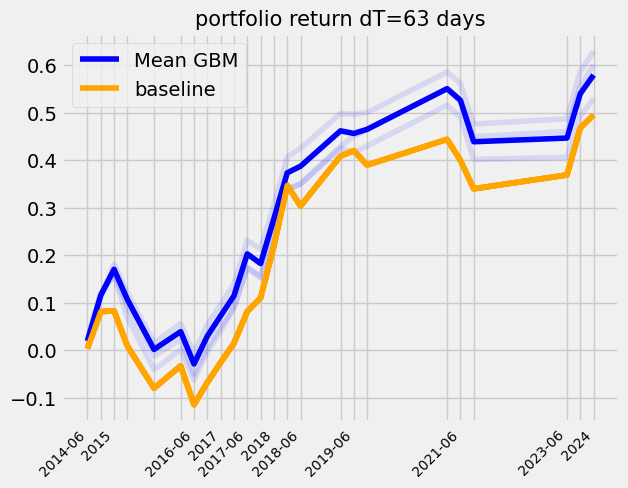

In [70]:
Rtemp=[]
for ii in range(3):
    Trading=63
    dfre=pd.read_csv('simulations/Returns_rho90T='+str(Trading)+'_'+str(ii)+'.csv')
    Rsimu=dfre['Rsim'].tolist()
    Rpast=dfre['Rpast'].tolist()
    yr=dfre['yr'].tolist()
    

    
    Rsimun=[]
    Rpastn=[]
    rmul=Trading/252
    for i in range(len(Rsimu)):
        Rsimun.append(Rsimu[i]*rmul)
        Rpastn.append(Rpast[i]*rmul)
        
    Rtemp.append(Rsimun)
    yyt=[]
    for yyst in yr:
        yy=float(yyst)
        if yy-int(yy)==0:
            yyt.append(str(int(yy)))
        elif yy-(int(yy)+0.5)==0:
            yyt.append(str(int(yy))+'-06')
        else:
            yyt.append('')
    
    yrf=[float(i) for i in yr]
    
    
    print('sim',np.mean(Rsimun),np.std(Rsimun))
    print('past',np.mean(Rpastn),np.std(Rpastn))
    plt.plot(yrf,np.cumsum(Rsimun),color='blue',alpha=0.1)
    plt.plot(yrf,np.cumsum(Rpastn),color='orange',alpha=1)
    plt.xticks(yrf,yyt, rotation=45, ha='right', fontsize=10)

Rsimmean=np.mean(Rtemp[1:],axis=0)
plt.plot(yrf,np.cumsum(Rsimmean),color='blue',alpha=1,label='Mean GBM')
plt.plot(yrf,np.cumsum(Rpastn),color='orange',alpha=1,label='baseline')


    





plt.title('portfolio return dT=63 days', fontsize=15)


plt.legend()

pp=np.cumsum(Rpastn)
print(pp[-1])
pp=np.cumsum(Rsimmean)
print(pp[-1])

plt.savefig('portfolioreturnT63.png', bbox_inches='tight')